### This ananlysis uses FPL dataset from FPL API and Football Maganager dataset. The ultimate goal is to be able to build models to predict player points for the upcoming FPL game weeks.

Specifically, the analysis: 
    
* [Load in the FPL players datasets in JSON](#first-bullet)
* [Build pandas dataframes for 22/23 season with current price](#second-bullet)
* [Conduct some EDA on player value](#third-bullet)
* [Get past and future fixture data](#fourth-bullet)
* [Merge with Football Manager (FM) data](#fifth-bullet)
* [Split the data into train and test based on past and future fixtures](#sixth-bullet)
* [Additional EDA for modelling and data preprocessing](#seventh-bullet)
* [Find the optimal parameters for each model and evaluate performance](#eighth-bullet)
* [Fit the models for prediction](#nineth-bullet)
* [Make predictions](#tenth-bullet)

    
Questions targeted to answer: 
 - How to obtain FPL dataset in desired format ready for analysis?
 - What are the valuable players based on past game week performances given current price?
 - What are some good predictors of FPL player points for the upcoming game week?
 - What predictors are correlated, therefore should be dropped before modelling?
 - How to construct modelling to balance bias and variance?
 - How to finetune model parameters to avoid overfitting?
 - What is the predicted player points for upcoming FPL game week using models trained?

In [2726]:
# importing necessary libraries

# essentials
import numpy as np
import pandas as pd
import datetime
import requests
import json
from IPython.display import HTML
from numpy.random import random

# webscrapping
import webscrapping as ws
import config as cf
from bs4 import BeautifulSoup

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA, KernelPCA

# stats
import scipy.stats as stats
import pylab
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# miscellenous
import warnings
import chardet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### A detailed guide to all currently available Fantasy Premier League API endpoints: 
https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19

In [2555]:
# function to request json over url
def getJson(base_url, end_point_path, element_id=''):
    return requests.get(base_url+end_point_path+str(element_id)).json()

## Load in the FPL players datasets in JSON <a class="anchor" id="first-bullet"></a>

In [2556]:
# get json data
base_url = 'https://fantasy.premierleague.com/api/'
end_point_general = 'bootstrap-static'
end_point_fixtures = 'fixtures'
end_point_player = 'element-summary/'

json = getJson(base_url, end_point_general)
# check keys
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

#### Desired data
##### Dataframe #1:
- all 38 game week of season 22/23
- all 10 games of each 38 game week of season 22/23
- all players involved [i.e. ~(11 + 4) x 2] for all 10 games in each 38 game week of season 22/23

Expected number of records = 38 x 10 x (11 + 4) x 2 = ~11.4K

##### Dataframe #2:
- current player info including cost, position etc.

##### Dataframe #3:
- join df1 and df2 to get aggregated df for info
- append future fixtures for prediction

## Build pandas dataframes for 22/23 season with current price <a class="anchor" id="second-bullet"></a>

In [2557]:
# build dataframes
df_elements = pd.DataFrame(json['elements'])
df_elements_types = pd.DataFrame(json['element_types'])
df_teams = pd.DataFrame(json['teams'])
total_players = json['total_players']
percentile = 0.8

df_elements_short = df_elements[['id', 'first_name', 'second_name','team','element_type','selected_by_percent','now_cost','minutes','transfers_in','value_season','event_points', 'total_points']]

# restructure player dataframe
df_elements_short['position'] = df_elements_short.element_type.map(df_elements_types.set_index('id').singular_name)
df_elements_short['team'] = df_elements_short.team.map(df_teams.set_index('id').name)
df_elements_short['name'] = df_elements_short['first_name'] + ' ' + df_elements_short['second_name']
df_elements_short['points_per_minute'] = df_elements_short['total_points'] / df_elements_short['minutes']
df_elements_short['points_per_minute'] = df_elements_short['points_per_minute'].fillna(0)
df_elements_short['now_cost'] = df_elements_short['now_cost'] / 10
df_elements_short['ppm_over_cost'] = df_elements_short['points_per_minute'] / df_elements_short['now_cost']
df_elements_short = df_elements_short[df_elements_short['minutes'] >= df_elements_short['minutes'].quantile(percentile)]
df_elements_short = df_elements_short[['id', 'name', 'team', 'position', 'selected_by_percent', 'minutes', 'now_cost', 'points_per_minute', 'ppm_over_cost']]

In [2558]:
# show value players
df_elements_short = df_elements_short.sort_values(by=['ppm_over_cost'], ascending=False)
df_elements_short.groupby(['position']).head(5)

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
25,26,Leandro Trossard,Arsenal,Midfielder,4.9,2237,7.0,0.068842,0.009835
429,402,Miguel Almirón Rejala,Newcastle,Midfielder,7.7,2487,6.5,0.063530,0.009774
291,275,Bernd Leno,Fulham,Goalkeeper,8.1,3240,4.5,0.043827,0.009739
117,113,David Raya Martin,Brentford,Goalkeeper,8.3,3420,5.0,0.048538,0.009708
19,20,William Saliba,Arsenal,Defender,15.5,2415,5.0,0.048447,0.009689
155,151,Joël Veltman,Brighton,Defender,1.3,2183,4.5,0.043518,0.009671
532,495,Ben Davies,Spurs,Defender,0.8,2284,4.5,0.043345,0.009632
135,131,Pervis Estupiñán,Brighton,Defender,51.0,2674,5.0,0.047868,0.009574
404,377,Diogo Dalot Teixeira,Man Utd,Defender,2.1,2152,5.0,0.047398,0.009480
239,226,Eberechi Eze,Crystal Palace,Midfielder,14.0,2631,6.5,0.060433,0.009297


In [2559]:
df_mo = df_elements_short[(df_elements_short['name']=='Mohamed Salah')]
df_mo

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
327,308,Mohamed Salah,Liverpool,Midfielder,23.6,3290,12.5,0.072644,0.005812


In [2560]:
element_id = 308
json = getJson(base_url, end_point_player, element_id)
# check keys
json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [2561]:
df_player_mo = pd.DataFrame(json['history_past'])
df_player_mo.tail()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded
3,2018/19,118748,130,132,259,3254,22,12,21,20,0,0,0,1,0,0,18,687,1186.8,973.9,2168.0,432.7,0,0.00,0.00,0.00,0.00
4,2019/20,118748,125,125,233,2879,19,10,16,26,0,0,0,1,0,0,26,661,1061.2,834.8,2156.0,405.1,0,0.00,0.00,0.00,0.00
5,2020/21,118748,120,129,231,3077,22,6,11,41,0,0,0,0,0,0,21,657,1056.0,825.7,1980.0,385.8,0,0.00,0.00,0.00,0.00
6,2021/22,118748,125,131,265,2758,23,14,17,22,0,0,1,1,0,0,29,756,1241.0,875.9,2230.0,434.8,0,0.00,0.00,0.00,0.00
7,2022/23,118748,130,131,239,3290,19,13,13,45,0,0,2,2,0,0,23,651,1067.4,899.2,1688.0,365.6,37,21.01,7.03,28.04,47.47


##### Data limiation
From observation above, FPL API doesn't have player level game week data for past seasons

##### Solution
Use github repo https://github.com/vaastav/Fantasy-Premier-League/tree/master loaded to local repo

In [2562]:
# helper functions to retrieve players master dataframe based on seasons interested
def getEncoding(file):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(100000))
    return result['encoding']

def getMasterDataFrame(seasons):
    for i, season in enumerate(seasons):

        file = 'Fantasy-Premier-League/data/'+ season +'/gws/merged_gw.csv'
        encoding = getEncoding(file)

        if i == 0:
            df_master = pd.read_csv(file, encoding=encoding)
            df_master['season'] = season
        else:
            df_temp = pd.read_csv(file, encoding=encoding)
            df_temp['season'] = season
            df_master = pd.concat([df_master, df_temp], ignore_index=True)
    return df_master

In [2563]:
# retrieve player master dataframe by specifying seasons intended to pull
# i.e. to pull player data for season 22/23, assign seasons = ['2022-23']
seasons = ['2022-23']

df_master = getMasterDataFrame(seasons)

In [2564]:
df_master = df_master.merge(df_elements_short[['name','selected_by_percent', 'now_cost']], on='name', how='left')

In [2565]:
# validation with seasonally aggregated data for Salah above
df_mo = df_master[df_master['name'].str.contains('Salah')]
df_mo.groupby(['season'])['minutes'].sum()

season
2022-23    3290
Name: minutes, dtype: int64

Validation complete, numbers match for previous season

## Conduct some EDA  on player value <a class="anchor" id="third-bullet"></a>

In [2566]:
# calculate efficient frontier player metrics
df_eft_raw = df_master[['name', 'team', 'element', 'total_points', 'minutes', 'season', 'now_cost']]
df_eft_raw['points_return'] = df_eft_raw['total_points'] / df_eft_raw['now_cost']
df_eft_raw['ptspm_return'] = (df_eft_raw['total_points'] / df_eft_raw['minutes']) / df_eft_raw['now_cost']

def getEfficientFrontierDF(df_eft_raw, df_live, return_str):
    df_std = df_eft_raw.groupby(['name', 'team'])[return_str].std().reset_index()
    df_std = df_std.rename(columns={df_std.columns[0]: 'name', df_std.columns[1]: 'team', df_std.columns[2]: 'pts_rt_std'})
    df_rt = df_eft_raw.groupby(['name', 'team'])[return_str].mean().reset_index()
    df_rt = df_rt.rename(columns={df_rt.columns[0]: 'name', df_rt.columns[1]: 'team', df_rt.columns[2]: 'ave_pts_rt'})
    df_eft = df_rt.merge(df_std, on=['name', 'team'], how='left')
    df_eft['adj_pts_rt'] = df_eft['ave_pts_rt'] / df_eft['pts_rt_std']
    df_eft = df_eft.merge(df_live[['name', 'team', 'position', 'selected_by_percent', 'now_cost']], on=['name', 'team'], how='right')
    
    # eleminate bottom 30 percent in terms of average points returned as % of current price
    df_eft = df_eft[df_eft['ave_pts_rt'] >= df_eft['ave_pts_rt'].quantile(0.3)]
    return df_eft.sort_values(by=['adj_pts_rt'], ascending=False)

df_eft = getEfficientFrontierDF(df_eft_raw, df_elements_short, 'points_return')
df_eft.head(20)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
106,Harry Kane,Spurs,0.553684,0.292542,1.892668,Forward,11.3,12.5
3,David Raya Martin,Brentford,0.873684,0.556866,1.568931,Goalkeeper,8.3,5.0
10,Benjamin White,Arsenal,0.746411,0.499791,1.493446,Defender,9.6,5.5
19,Kieran Trippier,Newcastle,0.801619,0.583540,1.373719,Defender,35.2,6.5
102,Bruno Borges Fernandes,Man Utd,0.544892,0.402388,1.354145,Midfielder,26.4,8.5
36,Aaron Ramsdale,Arsenal,0.752632,0.558829,1.346801,Goalkeeper,19.9,5.0
17,Sven Botman,Newcastle,0.754386,0.560136,1.346791,Defender,22.3,4.5
87,Alex Iwobi,Everton,0.602871,0.449565,1.341008,Midfielder,0.8,5.5
113,Mohamed Salah,Liverpool,0.503158,0.377947,1.331293,Midfielder,23.6,12.5
22,Gabriel Martinelli Silva,Arsenal,0.651316,0.492475,1.322535,Midfielder,14.1,8.0


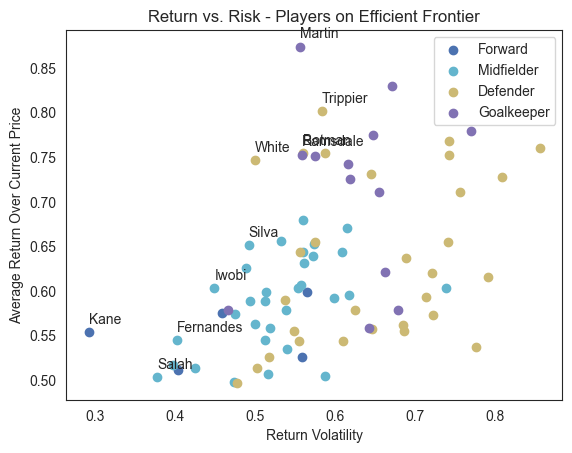

In [2567]:
# plot efficient frontier players
def plotEfficientFrontier(df_eft, y_offset, y_lable, x_max = None, x_min = None, y_max = None, y_min = None):
    colors = {'Forward': 'b', 'Midfielder': 'c', 'Defender': 'y', 'Goalkeeper': 'm'}

    for i, position in enumerate(colors.keys()):

        df = df_eft[df_eft['position'] == position]
        x = list(df['pts_rt_std'])
        y = list(df['ave_pts_rt'])
        plt.scatter(x, y, color=colors[position])
        for j, player in enumerate(df['name']):
            if float(list(df['adj_pts_rt'])[j]) >= df['adj_pts_rt'].quantile(0.9):
                plt.annotate(player.split(' ')[-1], (x[j], y[j] + y_offset))

    plt.legend(colors.keys(),
            bbox_to_anchor=(1 , 1),
            ncol=1)
    plt.title('Return vs. Risk - Players on Efficient Frontier')
    plt.xlabel('Return Volatility')
    plt.ylabel(y_lable)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

plotEfficientFrontier(df_eft, 0.01, 'Average Return Over Current Price')

##### Using average game week return over current price as the numerator penalizes player's injury and assumes long-term player ownership
##### Use average return per minute over current price as the numerator below to avoid bias

In [2568]:
df_eft_adj = getEfficientFrontierDF(df_eft_raw, df_elements_short, 'ptspm_return')
df_eft_adj.head(50)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
63,Sean Longstaff,Newcastle,0.008055,0.003905,2.062893,Midfielder,0.2,5.0
3,David Raya Martin,Brentford,0.009708,0.006187,1.568931,Goalkeeper,8.3,5.0
38,Andreas Hoelgebaum Pereira,Fulham,0.008128,0.005267,1.543249,Midfielder,3.0,5.5
27,Joe Willock,Newcastle,0.008661,0.005727,1.512193,Midfielder,1.1,5.5
0,Leandro Trossard,Arsenal,0.011563,0.007906,1.462607,Midfielder,4.9,7.0
11,Dan Burn,Newcastle,0.009552,0.006631,1.440494,Defender,3.3,4.5
50,Kenny Tete,Fulham,0.007956,0.005597,1.421591,Defender,0.6,4.5
55,Lucas Tolentino Coelho de Lima,West Ham,0.007621,0.005493,1.387251,Midfielder,1.4,6.0
19,Kieran Trippier,Newcastle,0.009090,0.006622,1.372815,Defender,35.2,6.5
10,Benjamin White,Arsenal,0.009931,0.007297,1.360858,Defender,9.6,5.5


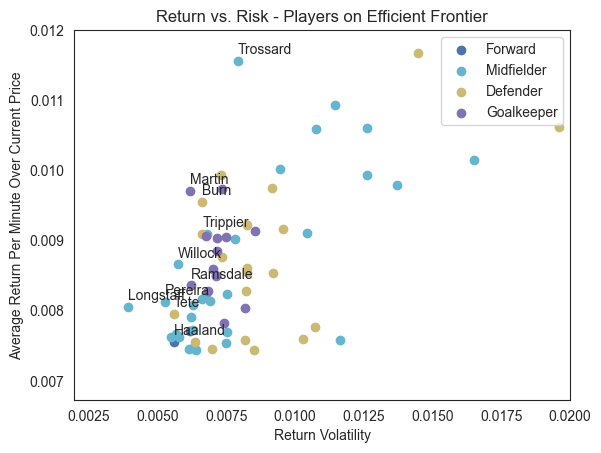

In [2569]:
plotEfficientFrontier(df_eft_adj, 0.0001, 'Average Return Per Minute Over Current Price', x_max=0.02, y_max=0.012)

Some noteworthy players with high value with consitency in past fixtures include:
- Leandro Trossard
- David Raya Martin
- Dan Burn
- Kieran Trippier
- Benjamin White
- Gabriel Martinelli Silva
- Ethan Pinnock
- William Saliba

##### Data limiation
Predictors from FPL (i.e. threat, ICT index, influence) are most lagging indicators, lack of player attributes predictors

##### Solution
Feature engineer player attribute predictors from Football Manager

## Get past and future fixture data <a class="anchor" id="fourth-bullet"></a>

In [2570]:
# get historical game info
df_master = df_master[df_master['season'] == '2022-23'][['name', 'position', 'team', 'kickoff_time', 'minutes', 'opponent_team', 'total_points', 'was_home', 'GW', 'season']]
# print(df_master.dtypes)
df_master.shape

(26505, 10)

In [2571]:
file_team_pst_ss = 'Fantasy-Premier-League/data/2022-23/teams.csv'

encoding = getEncoding(file_team_pst_ss)

df_team_pst_ss = pd.read_csv(file_team_pst_ss, encoding = encoding)

df_team_pst_ss.columns = 'opponent_team_' + df_team_pst_ss.columns

df_team_pst_ss.head(10)

,opponent_team_code,opponent_team_draw,opponent_team_form,opponent_team_id,opponent_team_loss,opponent_team_name,opponent_team_played,opponent_team_points,opponent_team_position,opponent_team_short_name,opponent_team_strength,opponent_team_team_division,opponent_team_unavailable,opponent_team_win,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,opponent_team_pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,4,NaN,False,0,1245,1285,1250,1250,1240,1320,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,3,NaN,False,0,1070,1100,1070,1075,1070,1130,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,2,NaN,False,0,1035,1095,1020,1110,1050,1080,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,3,NaN,False,0,1115,1180,1100,1160,1130,1200,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,3,NaN,False,0,1170,1175,1140,1150,1200,1200,131
5,8,0,NaN,6,0,Chelsea,0,0,0,CHE,3,NaN,False,0,1165,1220,1190,1220,1140,1220,4
6,31,0,NaN,7,0,Crystal Palace,0,0,0,CRY,3,NaN,False,0,1085,1100,1110,1110,1060,1090,6
7,11,0,NaN,8,0,Everton,0,0,0,EVE,3,NaN,False,0,1055,1095,1070,1100,1040,1090,7
8,54,0,NaN,9,0,Fulham,0,0,0,FUL,3,NaN,False,0,1095,1100,1070,1065,1120,1140,34
9,13,0,NaN,10,0,Leicester,0,0,0,LEI,3,NaN,False,0,1130,1115,1065,1110,1200,1120,26


In [2572]:
df_master = df_master.merge(df_team_pst_ss[['opponent_team_id', 'opponent_team_name']], how='left', left_on='opponent_team', right_on='opponent_team_id')

In [2573]:
print(df_master.dtypes)
df_master.head()

name                  object
position              object
team                  object
kickoff_time          object
minutes                int64
opponent_team          int64
total_points           int64
was_home                bool
GW                     int64
season                object
opponent_team_id       int64
opponent_team_name    object
dtype: object


,name,position,team,kickoff_time,minutes,opponent_team,total_points,was_home,GW,season,opponent_team_id,opponent_team_name
0,Nathan Redmond,MID,Southampton,2022-08-06T14:00:00Z,1,18,1,False,1,2022-23,18,Spurs
1,Junior Stanislas,MID,Bournemouth,2022-08-06T14:00:00Z,1,2,1,True,1,2022-23,2,Aston Villa
2,Armando Broja,FWD,Chelsea,2022-08-06T16:30:00Z,15,8,1,False,1,2022-23,8,Everton
3,Fabian Schär,DEF,Newcastle,2022-08-06T14:00:00Z,90,16,15,True,1,2022-23,16,Nott'm Forest
4,Jonny Evans,DEF,Leicester,2022-08-07T13:00:00Z,90,4,1,True,1,2022-23,4,Brentford


In [2574]:
# get future fixture info
json = getJson(base_url, end_point_fixtures)
df_fix = pd.DataFrame(json)

# only get confirmed fixtures
df_fix = df_fix.dropna(subset=['kickoff_time'])
df_fix = df_fix[['event', 'kickoff_time', 'minutes', 'team_a', 'team_h']]
df_fix['event'] = df_fix['event'].astype('int')
df_fix.shape

(378, 5)

In [2575]:
# create team dataframe based on fixtures for both home and away teams
df_fix_home = df_fix.merge(df_teams[['id', 'name']], how='left', left_on='team_h', right_on='id')[['kickoff_time', 'minutes', 'name', 'id', 'event', 'team_a']]
df_fix_away = df_fix.merge(df_teams[['id', 'name']], how='left', left_on='team_a', right_on='id')[['kickoff_time', 'minutes', 'name', 'id', 'event', 'team_h']]
df_fix_home = df_fix_home.rename(columns={'team_a': 'opponent_team', 'event': 'GW', 'name': 'team'})
df_fix_away = df_fix_away.rename(columns={'team_h': 'opponent_team', 'event': 'GW', 'name': 'team'})
df_fix_home['was_home'] = True
df_fix_away['was_home'] = False
print(df_fix_home.shape)
print(df_fix_away.shape)

# append home and away games for each team
df_all_teams = pd.concat([df_fix_home, df_fix_away], axis=0)
df_all_teams['total_points'] = 0
df_all_teams['season'] = '2023-24'
df_all_teams = df_all_teams[['team', 'kickoff_time', 'minutes', 'opponent_team', 'total_points', 'was_home', 'GW', 'season']]
print(df_all_teams.shape)

(378, 7)
(378, 7)
(756, 8)


In [2576]:
# get player info before joining on team fixtures
df_elements['position'] = df_elements.element_type.map(df_elements_types.set_index('id').singular_name)
df_elements['team'] = df_elements.team_code.map(df_teams.set_index('code').name)
df_elements['name'] = df_elements['first_name'] + ' ' + df_elements['second_name']
print(df_elements.shape)

(613, 90)


In [2577]:
# merge player info with team fixtures
df_player_fix = df_all_teams.merge(df_elements[['team', 'position', 'name']], on='team', how='left')

In [2578]:
# shorten position name
conditions = [df_player_fix['position'] == 'Goalkeeper', df_player_fix['position'] == 'Defender', \
              df_player_fix['position'] == 'Midfielder', df_player_fix['position'] == 'Forward']
pos = ['GK', 'DEF', 'MID', 'FWD']
df_player_fix['position'] = np.select(conditions, pos, default='')

# ensure column names order and datatypes match df_master
df_player_fix['GW'] = df_player_fix['GW'].astype(np.int64)

# assume all players plays 90 minutes for future fixtures
df_player_fix['minutes'] = 90
df_player_fix = df_player_fix[['name', 'position', 'team', 'kickoff_time', 'minutes', 'opponent_team', 'total_points', 'was_home', 'GW', 'season']]

In [2579]:
# print(df_player_fix['position'].unique())
print(df_player_fix.shape)
print(df_player_fix.dtypes)
df_player_fix.head()

(23165, 10)
name             object
position         object
team             object
kickoff_time     object
minutes           int64
opponent_team     int64
total_points      int64
was_home           bool
GW                int64
season           object
dtype: object


,name,position,team,kickoff_time,minutes,opponent_team,total_points,was_home,GW,season
0,Enock Agyei,MID,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24
1,Ameen Al-Dakhil,DEF,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24
2,Samuel Bastien,MID,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24
3,Manuel Benson Hedilazio,MID,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24
4,Jordan Beyer,DEF,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24


In [2580]:
df_teams.columns = 'opponent_team_' + df_teams.columns

In [2581]:
df_player_fix = df_player_fix.merge(df_teams[['opponent_team_id', 'opponent_team_name']], how='left', left_on='opponent_team', right_on='opponent_team_id')

In [2582]:
print(df_player_fix.dtypes)
df_player_fix.head()

name                  object
position              object
team                  object
kickoff_time          object
minutes                int64
opponent_team          int64
total_points           int64
was_home                bool
GW                     int64
season                object
opponent_team_id       int64
opponent_team_name    object
dtype: object


,name,position,team,kickoff_time,minutes,opponent_team,total_points,was_home,GW,season,opponent_team_id,opponent_team_name
0,Enock Agyei,MID,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24,13,Man City
1,Ameen Al-Dakhil,DEF,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24,13,Man City
2,Samuel Bastien,MID,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24,13,Man City
3,Manuel Benson Hedilazio,MID,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24,13,Man City
4,Jordan Beyer,DEF,Burnley,2023-08-11T19:00:00Z,90,13,0,True,1,2023-24,13,Man City


In [2583]:
# merge future fixture with past fixtures and season
df_master = pd.concat([df_master, df_player_fix], axis=0)
df_master.shape

(49670, 12)

In [2584]:
# reformat columns to be useful for analysis
# create AM/PM and weekday columns for when the game was held
df_master['kickoff_time'] = pd.to_datetime(df_master['kickoff_time'], format='%Y-%m-%dT%H:%M:%SZ')
df_master['AM/PM'] = df_master['kickoff_time'].dt.strftime('%p')
df_master['weekday'] = df_master['kickoff_time'].dt.dayofweek

# chang was_home column to binary
df_master['was_home'] = np.where(df_master['was_home'] == False, 0, 1)

In [2585]:
df_master = df_master[['name', 'position', 'team', 'minutes', 'total_points', 'was_home', 
                       'GW', 'season', 'opponent_team_name', 'AM/PM', 'weekday']]

In [2586]:
df_master[(df_master['team'] == 'Liverpool') & (df_master['GW'] == 1) & (df_master['season'] == '2023-24')]

,name,position,team,minutes,total_points,was_home,GW,season,opponent_team_name,AM/PM,weekday
11822,Adrián San Miguel del Castillo,GK,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11823,Trent Alexander-Arnold,DEF,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11824,Alisson Ramses Becker,GK,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11825,Stefan Bajcetic,MID,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11826,Darwin Núñez Ribeiro,FWD,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11827,Diogo Teixeira da Silva,MID,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11828,Harvey Elliott,MID,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11829,Fabio Henrique Tavares,MID,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11830,Cody Gakpo,FWD,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6
11831,Joe Gomez,DEF,Liverpool,90,0,0,1,2023-24,Chelsea,PM,6


## Merge with Football Manager (FM) data <a class="anchor" id="fifth-bullet"></a>

In [2587]:
file_fm = 'FM/FM 2023.csv'

encoding = getEncoding(file_fm)

df_fm = pd.read_csv(file_fm, encoding = encoding)

df_fm = df_fm.drop_duplicates()

df_fm.head()

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,16,16,17,6,17,7,9,18,16,9,18,12,14,13,15,15,20,18,17,16,13,14,11,14,15,15,13,14,10,16,14,17,13,15,6,15,7,14,1,3,1,3,3,3,3,3,3,2,1,13,17,13,14,11,18,16,13,1,1,1,1,1,1,12,15,20,15,14,20,14,12,181,68,16,20,347975206,9450,9400,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,17,18,12,7,13,4,4,15,18,4,17,6,17,12,18,14,15,15,15,18,13,18,3,10,10,20,16,15,8,15,20,14,11,15,7,16,7,14,2,2,2,1,1,2,1,3,2,1,2,15,20,8,14,16,16,12,13,1,1,1,1,1,1,1,10,1,10,19,1,17,20,178,73,10,20,347975206,9398,9398,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,19,18,15,17,12,3,7,13,20,7,16,15,19,16,17,17,13,17,20,14,15,19,7,12,12,14,13,19,15,20,14,18,16,18,8,15,2,8,2,2,3,2,3,2,3,3,2,1,1,15,20,15,10,16,18,10,11,1,1,1,1,1,1,1,1,1,1,10,12,8,20,185,81,13,20,347975206,9300,9400,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,18,16,13,15,13,5,6,13,17,7,15,13,18,15,18,15,14,13,20,16,13,18,7,13,13,17,16,17,18,19,19,14,17,17,9,17,12,10,2,4,1,3,2,2,2,2,3,3,2,16,20,12,15,18,17,10,12,1,1,1,1,1,1,1,1,1,1,1,1,1,20,195,88,20,11,347975206,9250,9250,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,17,17,12,10,13,6,7,15,17,7,17,11,16,11,15,15,17,15,18,15,11,18,9,15,16,18,16,18,8,17,18,15,15,15,6,16,4,7,3,2,2,1,2,1,3,2,3,3,2,16,19,8,13,16,18,16,17,1,1,1,1,1,1,1,1,1,1,17,12,20,19,175,72,20,8,347975206,9400,9445,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755


In [2588]:
# find player name in FM mannually before join FM data
name_match_list_fm = [['Miguel Almirón Rejala', 'Miguel Almirón'], 
                        ['David Raya Martin', 'David Raya'],
                        ['Diogo Dalot Teixeira', 'Diogo Dalot'],
                        ['Eberechi Eze', 'Ebere Eze'],
                        ['José Malheiro de Sá', 'José Sá'],
                        ['Lukasz Fabianski', 'Łukasz Fabiański'],
                        ['Gabriel Martinelli Silva', 'Gabriel Martinelli'],
                        ['Alisson Ramses Becker', 'Alisson'],
                        ['Douglas Luiz Soares de Paulo', 'Douglas Luiz'],
                        ['Norberto Murara Neto', 'Pedro Neto'],
                        ['Emiliano Martínez Romero', 'Emiliano Martínez'],
                        ['Gabriel dos Santos Magalhães', 'Gabriel'],
                        ['Andreas Hoelgebaum Pereira', 'Andreas Pereira'],
                        ['Emiliano Buendía Stati', 'Emiliano Buendía'],
                        ['Lucas Tolentino Coelho de Lima', 'Lucas Paquetá'],
                        ['Bernardo Veiga de Carvalho e Silva', 'Bernardo Silva'],
                        ['Ezri Konsa Ngoyo', 'Ezri Konsa'],
                        ['Joelinton Cássio Apolinário de Lira', 'Joelinton'],
                        ['Ederson Santana de Moraes', 'Ederson'],
                        ['Thiago Emiliano da Silva', 'Thiago Silva'],
                        ['Rodrigo Hernandez', 'Rodri'],
                        ['Bobby De Cordova-Reid', 'Bobby Decordova-Reid'],
                        ['Bruno Guimarães Rodriguez Moura', 'Bruno Guimarães'],
                        ['Matheus Luiz Nunes', 'Matheus Nunes'],
                        ['Nélson Cabral Semedo', 'Nélson Semedo'],
                        ['Vitalii Mykolenko', 'Vitaliy Mykolenko'],
                        ['Bruno Borges Fernandes', 'Bruno Fernandes'],
                        ['Jefferson Lerma Solís', 'Jefferson Lerma'],
                        ['Son Heung-min', 'Heung-Min Son'],
                        ['João Palhinha Gonçalves', 'João Palhinha'],
                        ['Fabio Henrique Tavares', 'Fabinho2'],
                        ['Moisés Caicedo Corozo', 'Moisés Caicedo'],
                        ['David De Gea Quintana', 'David De Gea'],
                        ['Rúben da Silva Neves', 'Rúben Neves'],
                        ['Tomas Soucek', 'Tomáš Souček'],
                        ['Ilkay Gündogan', 'İlkay Gündogan'],
                        ['Marc Roca Junqué', 'Marc Roca'],
                        ['Renan Augusto Lodi dos Santos', 'Renan Lodi'],
                        ['Mohamed Elyounoussi', 'Moi Elyounoussi'],
                        ['Vladimir Coufal', 'Vladimír Coufal'],
                        ['Willian Borges da Silva', 'Willian'],
                        ['Jorge Luiz Frello Filho', 'Jorginho'],
                        ['Carlos Henrique Casimiro', 'Casemiro'],
                        ['Gabriel Fernando de Jesus', 'Gabriel Jesus'],
                        ['Rúben Gato Alves Dias', 'Rúben Dias'],
                        ['Rodrigo Moreno', 'Rodrigo'],
                        ['Antony Matheus dos Santos', 'Antony'],
                        ['João Filipe Iria Santos Moutinho', 'João Moutinho'],
                        ['Daniel Castelo Podence', 'Daniel Podence'],
                        ['Emerson Leite de Souza Junior', 'Emerson Royal'],
                        ['Mateo Kovacic', 'Mateo Kovačić'],
                        ['Darwin Núñez Ribeiro', 'Darwin Núñez'],
                        ['Marc Cucurella Saseta', 'Marc Cucurella'],
                        ['Pablo Fornals Malla', 'Pablo Fornals'],
                        ['Adama Traoré Diarra', 'Adama Traoré'],
                        ['Joseph Gomez', 'Joe Gomez'],
                        ['Felipe Augusto de Almeida Monteiro', 'Felipe'],
                        ['Junior Firpo Adames', 'Júnior Firpo'],
                        ['Emerson Palmieri dos Santos', 'Emerson'],
                        ['Hugo Bueno López', 'Hugo Bueno'],
                        ['Jonathan Castro Otto', 'Jonny'],
                        ['Thiago Alcántara do Nascimento', 'Thiago'],
                        ['Diego Da Silva Costa', 'Diego Costa'],
                        ['Frederico Rodrigues de Paula Santos', 'Fred'],
                        ['Joe Ayodele-Aribo', 'Joe Aribo'],
                        ['Lyanco Silveira Neves Vojnovic', 'Lyanco'],
                        ['Diogo Teixeira da Silva', 'Diogo Jota'],
                        ['Hwang Hee-chan', 'Hwang Hee-Chan'],
                        ['Mads Roerslev Rasmussen', 'Mads Roerslev'],
                        ['Carlos Vinícius Alves Morais', 'Carlos Vinícius'],
                        ['Mathias Jorgensen', 'Mathias Jensen'],
                        ['Joel Matip', 'Joël Matip'], 
                        ['Richarlison de Andrade', 'Richarlison'],
                        ['Toti António Gomes', 'Toti'],
                        ['Pedro Lomba Neto', 'Pedro Neto'],
                        ['Matheus Santos Carneiro Da Cunha', 'Matheus Cunha'],
                        ['Duje Caleta-Car', 'Duje Ćaleta-Car'],
                        ['João Félix Sequeira', 'João Félix'],
                        ['Luis Sinisterra Lucumí', 'Luis Sinisterra'],
                        ['Edouard Mendy', 'Édouard Mendy'],
                        ['Philippe Coutinho Correia', 'Philippe Coutinho'],
                        ['Konstantinos Tsimikas', 'Kostas Tsimikas'],
                        ['Gonçalo Manuel Ganchinho Guedes', 'Gonçalo Guedes'],
                        ['Moussa Djenepo', 'Moussa Djénépo'],
                        ['Mykhailo Mudryk', 'Mykhaylo Mudryk'],
                        ['João Victor Gomes da Silva', 'João Gomes'],
                        ['Matt Targett', 'Matthew Targett'],
                        ['Çaglar Söyüncü', 'Çağlar Söyüncü'],
                        ['Stefan Bajcetic', 'Stefan Bajčetić'],
                        ['Cristiano Ronaldo dos Santos Aveiro', 'Cristiano Ronaldo'],
                        ['Luka Milivojevic', 'Luka Milivojević'],
                        ['Fábio Ferreira Vieira', 'Fábio Vieira'],
                        ['Ricardo Barbosa Pereira', 'Ricardo Pereira'],
                        ['Hamed Traorè', 'Hamed Traoré'],
                        ['Sasa Lukic', 'Saša Lukić'],
                        ['Fábio Freitas Gouveia Carvalho', 'Fábio Carvalho'],
                        ['Naby Keita', 'Naby Keïta'],
                        ['Stefan Ortega Moreno', 'Stefan Ortega'],
                        ['Cédric Alves Soares', 'Cédric'],
                        ['Diego Carlos Santos Silva', 'Diego Carlos'],
                        ['Gustavo Henrique Furtado Scarpa', 'Gustavo Scarpa'],
                        ['Jeremy Sarmiento Morante', 'Jeremy Sarmiento'],
                        ['Martin Dubravka', 'Martin Dúbravka'],
                        ['Juan Larios López', 'Juan Larios'],
                        ['Bryan Gil Salvatierra', 'Bryan Gil'],
                        ['Lucas Rodrigues Moura da Silva', 'Lucas Moura'],
                        ['Oriol Romeu Vidal', 'Oriol Romeu'],
                        ['Sergi Canós Tenés', 'Sergi Canos'],
                        ['David Datro Fofana', 'Datro Fofana'],
                        ['Nathaniel Phillips', 'Nathan Phillips'],
                        ['Jairo Riedewald', 'Jaïro Riedewald'],
                        ['Facundo Pellistri Rebollo', 'Facundo Pellistri'],
                        ['Sasa Kalajdzic', 'Saša Kalajdžić'],
                        ['Javier Manquillo Gaitán', 'Javi Manquillo'],
                        ['Dominic Ballard', 'Dom Ballard'],
                        ['Rúben Nascimento Vinagre', 'Rúben Vinagre'],
                        ['Mateo Joseph Fernández', 'Mateo Joseph'],
                        ['Odeluga Offiah', 'Odel Offiah'],
                        ['Mislav Orsic', 'Mislav Oršić'],
                        ['Marcus Oliveira Alencar', 'Marquinhos2'],
                        ['Alexandre Moreno Lopera', 'Álex Moreno'],
                        ['Danilo dos Santos de Oliveira', 'Danilo1'],
                        ['João Neves Virgínia', 'João Neves'],
                        ['Joe Gomez', 'Joe Gomez'],
                        ['Mathias Jensen', 'Mathias Jensen'],
                        ['Álvaro Fernández Carreras', 'Álvaro Fernández1'],
                        ['Ivan Neves Abreu Cavaleiro', 'Ivan Cavaleiro'],
                        ['Ismaila Coulibaly	', 'Ismaïla Coulibaly'],
                        ['Ionuț Radu', 'Ionuţ Radu'],
                        ['Iliman Ndiaye', "Iliman N'Diaye"],
                        ['Igor Julio dos Santos de Paulo', 'Igor'],
                        ['Hwang Ui-jo', 'Hwang Ui-Jo'],
                        ['João Pedro Junqueira de Jesus', 'João Pedro1'],
                        ['Wesley Moraes Ferreira da Silva', 'Wesley Moraes'],
                        ['Vladimir Coufal', 'Vladimír Coufal'],
                        ['Tomas Soucek', 'Tomáš Souček'],
                        ['Sasa Lukic', 'Saša Lukić'],
                        ['Romelu Lukaku Bolingoli', 'Romelu Lukaku'],
                        ['Rodrigo Muniz Carvalho', 'Rodrigo Muniz'],
                        ['Olu Aina', 'Ola Aina'],
                        ['Nuno Varela Tavares', 'Nuno Tavares'],
                        ['Milos Kerkez', 'Miloš Kerkez'],
                        ['Hannibal Mejbri', 'Hannibal'],
                        ['Abdul Rahman Baba', 'Baba Rahman'],
                        ['Ângelo Gabriel Borges Damaceno', 'Ângelo'],
                        ['Andrey Nascimento dos Santos', 'Andrey Santos'],
                        ['Bruno Cavaco Jordão', 'Bruno Jordão'],
                        ['Brandon Aguilera Zamora', 'Brandon Aguilera'],
                        ['Braian Ojeda Rodríguez', 'Braian Ojeda'],
                        ['Arnaut Danjuma Groeneveld', 'Arnaut Danjuma'],
                        ['André Tavares Gomes', 'André Gomes'],
                        ['Eric Bailly', 'Éric Bailly'],
                        ['Adrián San Miguel del Castillo', 'Adrián'],
                        ['Pelly Ruddock Mpanzu', 'Pelly-Ruddock Mpanzu'],
                        ['Bailey Peacock-Farrell', 'Bailey Peacock-Farrell'],
                        ['Arijanet Murić', 'Arijanet Muric'],
                        ['Mateo Kovacic	', 'Mateo Kovačić']]
df_name_match_fm = pd.DataFrame(name_match_list_fm, columns=['fpl_name', 'fm_name'])

df_fm = df_fm.merge(df_name_match_fm, left_on=['Name'], right_on=['fm_name'], how='left')

In [2589]:
df_fm['Merged_Name'] = np.where(df_fm['fpl_name'].notna(), df_fm['fpl_name'], df_fm['Name'])

# add player's best positions column
player_positions = ['GK', 'DL', 'DC', 'DR', 'WBL', 'WBR', 'DM', 'ML', 'MC', 'MR', 'AML', 'AMC', 'AMR', 'ST']
df_fm['best_positions'] = df_fm[player_positions].apply(lambda x: ' '.join(i for i in x[x==20].index), axis=1)
df_fm.head(10)

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID,fpl_name,fm_name,Merged_Name,best_positions
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,16,16,17,6,17,7,9,18,16,9,18,12,14,13,15,15,20,18,17,16,13,14,11,14,15,15,13,14,10,16,14,17,13,15,6,15,7,14,1,3,1,3,3,3,3,3,3,2,1,13,17,13,14,11,18,16,13,1,1,1,1,1,1,12,15,20,15,14,20,14,12,181,68,16,20,347975206,9450,9400,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457,NaN,NaN,Kevin De Bruyne,MC AMC
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,17,18,12,7,13,4,4,15,18,4,17,6,17,12,18,14,15,15,15,18,13,18,3,10,10,20,16,15,8,15,20,14,11,15,7,16,7,14,2,2,2,1,1,2,1,3,2,1,2,15,20,8,14,16,16,12,13,1,1,1,1,1,1,1,10,1,10,19,1,17,20,178,73,10,20,347975206,9398,9398,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014,NaN,NaN,Kylian Mbappé,ST
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,19,18,15,17,12,3,7,13,20,7,16,15,19,16,17,17,13,17,20,14,15,19,7,12,12,14,13,19,15,20,14,18,16,18,8,15,2,8,2,2,3,2,3,2,3,3,2,1,1,15,20,15,10,16,18,10,11,1,1,1,1,1,1,1,1,1,1,10,12,8,20,185,81,13,20,347975206,9300,9400,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601,NaN,NaN,Robert Lewandowski,ST
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,18,16,13,15,13,5,6,13,17,7,15,13,18,15,18,15,14,13,20,16,13,18,7,13,13,17,16,17,18,19,19,14,17,17,9,17,12,10,2,4,1,3,2,2,2,2,3,3,2,16,20,12,15,18,17,10,12,1,1,1,1,1,1,1,1,1,1,1,1,1,20,195,88,20,11,347975206,9250,9250,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241,NaN,NaN,Erling Haaland,ST
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,17,17,12,10,13,6,7,15,17,7,17,11,16,11,15,15,17,15,18,15,11,18,9,15,16,18,16,18,8,17,18,15,15,15,6,16,4,7,3,2,2,1,2,1,3,2,3,3,2,16,19,8,13,16,18,16,17,1,1,1,1,1,1,1,1,1,1,17,12,20,19,175,72,20,8,347975206,9400,9445,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755,NaN,NaN,Mohamed Salah,AMR
5,Karim Benzema,S,34,185,185,"France,Algeria",R. Madrid,10,13,16,17,20,12,15,12,7,7,18,15,9,20,7,14,10,18,14,18,17,18,17,11,15,12,16,14,15,14,15,11,11,15,14,14,14,4,15,8,8,3,1,2,3,3,1,2,4,1,2,2,15,14,17,12,15,15,17,18,1,1,1,1,1,1,1,1,1,1,13,12,8,20,185,82,17,20,102955257,9250,8750,8750,North_African__Middle_Eastern,183,9,1987/12/19,97,37,321918.0,NaN,8435089,NaN,NaN,Karim Benzema,ST
6,Harry Kane,S C,28,183,185,"England,Republic of Ireland",Tottenham Hotspur,9,15,14,19,15,10,15,15,6,10,18,20,11,16,11,15,14,18,15,18,18,19,12,15,16,12,18,16,12,12,14,13,16,14,16,15,17,8,14,12,9,1,1,3,1,3,2,1,2,2,3,1,10,18,12,18,18,20,11,16,1,1,1,1,1,1,1,1,11,1,13,15,1,20,188,86,19,20,347975206,9200,9200,8750,Northern_European,183,4,1993/7/28,73,50,231983.0,NaN,28049320,NaN,NaN,Harry Kane,ST
7,Thibaut Courtois,GK,30,181,181,Belgium,R. Madrid,6,1,10,2,10,9,10,1,2,3,13,5,3,12,8,15,15,12,16,9,16,16,14,13,3,16,14,11,12,13,14,18,12,11,8,14,16,5,18,5,15,20,16,14,5,16,16,18,19,12,6,15,14,14,10,15,16,15,14,14,20,1,1,1,1,1,1,1,1,1,1,1,1,1,199,96,20,9,255605643,9050,8750,8500,Northern_European,178,

In [2590]:
df_insights = df_master.merge(df_fm, left_on=['name'], right_on=['Merged_Name'], how='left')
df_insights.shape

(49763, 113)

In [2591]:
df_insights = df_insights[df_insights['minutes'] != 0]
df_insights.shape

(34585, 113)

In [2592]:
df_check = df_insights[df_insights['Age'].isna()].groupby('name')['minutes'].sum().reset_index()
df_check = df_check.rename(columns={df_check.columns[0]: 'name', df_check.columns[1]: 'minutes'})
df_check = df_check.sort_values(by=['minutes'], ascending=False)

In [2593]:
# ensure this returns an empty array to ensure player mapping complete
# otherwise more manual mapping on player name required
print('Number of unmapped players: '+ str(df_insights[df_insights['Age'].isna()]['name'].nunique()))
print('Creating unmapped player list at current directory...')
df_check.to_csv('Output/manualMappingFile.csv')

Number of unmapped players: 105
Creating unmapped player list at current directory...


In [2594]:
df_insights = df_insights[df_insights['Age'].notna()]
print('Number of unmapped players after dropping unmapped players: '+ str(df_insights[df_insights['Age'].isna()]['name'].nunique()))

Number of unmapped players after dropping unmapped players: 0


In [2595]:
# for testing fpl player name in matching fpl name with fm name
# df_insights[df_insights['name'].str.contains("hann Berg Gudmundsson")].head()

In [2596]:
# ways to look around to match player name between FPL and FM
# df_insights[df_insights['name'].str.contains('Jason Steele')].head()

# for testing fm player name in matching fpl name with fm name
# name_try = "Jóhann Berg Gudmundsson"
# df_fm[df_fm['Name'].str.contains(name_try)]

# club_try = 'Wolv'
# df_fm[df_fm['Club'].str.contains(club_try, na=False)]

In [2597]:
df_insights.head()

,name,position,team,minutes,total_points,was_home,GW,season,opponent_team_name,AM/PM,weekday,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID,fpl_name,fm_name,Merged_Name,best_positions
0,Nathan Redmond,MID,Southampton,1,1,0,1,2022-23,Spurs,PM,5,Nathan Redmond,M/AM/S RLC,28.0,134.0,145.0,"England,Jamaica,Republic of Ireland",Beşiktaş A.Ş.,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,8.0,13.0,5.0,15.0,12.0,13.0,15.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,14.0,20.0,18.0,17.0,18.0,173.0,75.0,8.0,20.0,5983867.0,6800.0,6700.0,5700.0,Mixed_Race,124.0,12.0,1994/3/6,1.0,0.0,48076.0,NaN,28053447.0,NaN,NaN,Nathan Redmond,AML
1,Junior Stanislas,MID,Bournemouth,1,1,1,1,2022-23,Aston Villa,PM,5,Junior Stanislas,M/AM RL,32.0,122.0,143.0,"England,Saint Lucia",AFC Bournemouth,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,12.0,14.0,3.0,13.0,10.0,16.0,8.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,1.0,17.0,20.0,13.0,20.0,1.0,183.0,77.0,9.0,20.0,2461823.0,6100.0,6100.0,4500.0,Mixed_Race,120.0,16.0,1989/11/26,0.0,0.0,28998.0,NaN,28006277.0,NaN,NaN,Junior Stanislas,AML AMR
2,Armando Broja,FWD,Chelsea,15,1,0,1,2022-23,Everton,PM,5,Armando Broja,AM/S RL,20.0,135.0,-85.0,"Albania,England",Chelsea,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,13.0,10.0,6.0,10.0,12.0,12.0,12.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,14.0,16.0,20.0,191.0,75.0,10.0,20.0,75046653.0,6750.0,6750.0,5500.0,Mediterranean_Hispanic,130.0,2.0,2001/9/10,14.0,4.0,86994.0,NaN,28121369.0,NaN,NaN,Armando Broja,ST
3,Fabian Schär,DEF,Newcastle,90,15,1,1,2022-23,Nott'm Forest,PM,5,Fabian Schär,D C,30.0,138.0,138.0,Switzerland,Newcastle United,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,10.0,13.0,6.0,12.0,14.0,15.0,14.0,16.0,1.0,1.0,20.0,10.0,1.0,8.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,188.0,84.0,12.0,20.0,38768484.0,6900.0,6750.0,5500.0,Northern_European,138.0,5.0,1991/12/20,71.0,8.0,52196.0,NaN,98007212.0,NaN,NaN,Fabian Schär,DC
4,Jonny Evans,DEF,Leicester,90,1,1,1,2022-23,Brentford,PM,6,Jonny Evans,D C,34.0,148.0,155.0,Northern Ireland,Leicester City,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,16.0,14.0,6.0,16.0,14.0,15.0,16.0,18.0,1.

In [2598]:
# load in prediction dataframe
player_attribute_list = ['ca', 'Corners', 'Crossing', 'Dribbling', \
                        'Finishing', 'First Touch', 'Free Kick Taking', 'Heading', 'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking', \
                        'Tackling', 'Technique', 'Aggressiion', 'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision', 'Decision', 'Determination', \
                        'Flair', 'Leadership', 'Off The Ball', 'Position.1', 'Teamwork', 'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach', \
                        'Natural Fitness', 'Pace', 'Stamina', 'Strength', 'Stability', 'Foul', 'Contest performance', 'Injury', 'diversity', 'Aerial Reach', \
                        'Command Of Area', 'Communication',	'Eccentricity', 'Handling',	'Kicking', 'One On Ones', 'Reflexes', 'Rushing Out', 'Punching', 'Throwing']

df_aggregate = df_insights[['position', 'best_positions', 'team', 'AM/PM', 'weekday', 'minutes', 'was_home', 'GW', 'Age', 'Height', 'Weight', 'Left Foot', 'Right Foot'] + player_attribute_list + \
                            ['opponent_team_name', 'total_points', 'name', 'season']]

In [2599]:
df_aggregate.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,name,season
0,MID,AML,Southampton,PM,5,1,0,1,28.0,173.0,75.0,8.0,20.0,134.0,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,Spurs,1,Nathan Redmond,2022-23
1,MID,AML AMR,Bournemouth,PM,5,1,1,1,32.0,183.0,77.0,9.0,20.0,122.0,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,Aston Villa,1,Junior Stanislas,2022-23
2,FWD,ST,Chelsea,PM,5,15,0,1,20.0,191.0,75.0,10.0,20.0,135.0,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,Everton,1,Armando Broja,2022-23
3,DEF,DC,Newcastle,PM,5,90,1,1,30.0,188.0,84.0,12.0,20.0,138.0,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,Nott'm Forest,15,Fabian Schär,2022-23
4,DEF,DC,Leicester,PM,6,90,1,1,34.0,188.0,77.0,16.0,20.0,148.0,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,Brentford,1,Jonny Evans,2022-23


In [2600]:
# df_def_ca_map = df_insights[(df_insights['position'].str.contains('|'.join(['GK', 'DEF'])))].groupby(['team', 'GW'])['ca'].mean().reset_index()
# df_def_ca_map = df_def_ca_map.rename(columns={df_def_ca_map.columns[0]: 'team', df_def_ca_map.columns[1]: 'GW', df_def_ca_map.columns[2]: 'team_def_ca'})
# df_aggregate = df_aggregate.merge(df_def_ca_map, how='left', on=['team', 'GW'])
# df_atk_ca_map = df_insights[(df_insights['position'].str.contains('|'.join(['MID', 'FWD'])))].groupby(['team', 'GW'])['ca'].mean().reset_index()
# df_atk_ca_map = df_atk_ca_map.rename(columns={df_atk_ca_map.columns[0]: 'team', df_atk_ca_map.columns[1]: 'GW', df_atk_ca_map.columns[2]: 'team_atk_ca'})
# df_aggregate = df_aggregate.merge(df_atk_ca_map, how='left', on=['team', 'GW'])

In [2601]:
# function to add a column with aggregated metric specified
def getAggregatedMetric(df, metric_name, position_field='position', agg_field_list=['team', 'GW'], attribute='ca', positions_list=None, opponent_dict=None):
    
    if opponent_dict:
        agg_field_list = agg_field_list + [position_field]
        df_map = pd.DataFrame()
        for key, lst in opponent_dict.items():
            # print(df_map.head())
            # print(key, lst, position_field, agg_field_list, attribute)
            # pick the best player attribute using max()
            df_temp = df[(df[position_field].str.contains('|'.join(lst)))].groupby(agg_field_list[:-1])[attribute].max().reset_index()
            df_temp[position_field] = key
            df_map = pd.concat([df_map, df_temp], ignore_index=True)
            # print(df_map.head())
        agg_field_list = ['opponent_team_name' if agg_field == 'team' else agg_field for agg_field in agg_field_list]
        df_map = df_map.rename(columns={'team': 'opponent_team_name'})
    else:
        df_map = df[(df[position_field].str.contains('|'.join(positions_list)))].groupby(agg_field_list)[attribute].mean().reset_index()
    df_map = df_map.rename(columns={attribute: metric_name})
    # print(df_map.tail())
    # print(df_map.shape)
    # print(agg_field_list)
    return df.merge(df_map, how='left', on=agg_field_list)

In [2602]:
df_aggregate = getAggregatedMetric(df_aggregate, positions_list=['GK', 'DEF'], metric_name='team_defence_ca')
df_aggregate = getAggregatedMetric(df_aggregate, positions_list=['MID', 'FWD'], metric_name='team_attack_ca')
df_aggregate.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,name,season,team_defence_ca,team_attack_ca
0,MID,AML,Southampton,PM,5,1,0,1,28.0,173.0,75.0,8.0,20.0,134.0,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,Spurs,1,Nathan Redmond,2022-23,135.500000,135.111111
1,MID,AML AMR,Bournemouth,PM,5,1,1,1,32.0,183.0,77.0,9.0,20.0,122.0,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,Aston Villa,1,Junior Stanislas,2022-23,127.176471,128.923077
2,FWD,ST,Chelsea,PM,5,15,0,1,20.0,191.0,75.0,10.0,20.0,135.0,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,Everton,1,Armando Broja,2022-23,143.958333,144.392857
3,DEF,DC,Newcastle,PM,5,90,1,1,30.0,188.0,84.0,12.0,20.0,138.0,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,Nott'm Forest,15,Fabian Schär,2022-23,134.761905,136.962963
4,DEF,DC,Leicester,PM,6,90,1,1,34.0,188.0,77.0,16.0,20.0,148.0,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,Brentford,1,Jonny Evans,2022-23,142.333333,148.666667


In [2603]:
# create a dictionary maps to opponennt positions based on player positions
# i.e. the player's performance will be directly related to how good the player's mapped opponents
opponent_dict = {
    'GK': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DL': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DC': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DR': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'WBL': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'WBR': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DM': ['GK','DL','DC','DR','WBL','WBR','DM'],
    'ML': ['GK','DC','DR','WBR','DM'],
    'MC': ['GK','DL','DC','DR','DM'],
    'MR': ['GK','DL','DC','WBL','DM'],
    'AML': ['GK','DC','DR','WBR'],
    'AMC': ['GK','DL','DC','DR','DM'],
    'AMR': ['GK','DL','DC','WBL'],
    'ST': ['GK','DL','DC','DR']
}

# only get the most attacking position out of all the best positions
df_aggregate['best_positions'] = np.where(df_aggregate['best_positions'].str.contains(' '), df_aggregate['best_positions'].str.split(' ').str[-1], df_aggregate['best_positions'])

# get opponent attributes
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_height', position_field='best_positions', attribute='Height', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_weight', position_field='best_positions', attribute='Weight', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_left_foot', position_field='best_positions', attribute='Left Foot', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_right_foot', position_field='best_positions', attribute='Right Foot', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_ca', position_field='best_positions', attribute='ca', opponent_dict=opponent_dict)
df_aggregate.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,name,season,team_defence_ca,team_attack_ca,opponent_height,opponent_weight,opponent_left_foot,opponent_right_foot,opponent_ca
0,MID,AML,Southampton,PM,5,1,0,1,28.0,173.0,75.0,8.0,20.0,134.0,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,Spurs,1,Nathan Redmond,2022-23,135.500000,135.111111,201.0,99.0,20.0,20.0,153.0
1,MID,AMR,Bournemouth,PM,5,1,1,1,32.0,183.0,77.0,9.0,20.0,122.0,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,Aston Villa,1,Junior Stanislas,2022-23,127.176471,128.923077,198.0,89.0,20.0,20.0,157.0
2,FWD,ST,Chelsea,PM,5,15,0,1,20.0,191.0,75.0,10.0,20.0,135.0,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,Everton,1,Armando Broja,2022-23,143.958333,144.392857,196.0,83.0,20.0,20.0,146.0
3,DEF,DC,Newcastle,PM,5,90,1,1,30.0,188.0,84.0,12.0,20.0,138.0,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,Nott'm Forest,15,Fabian Schär,2022-23,134.761905,136.962963,192.0,90.0,20.0,20.0,144.0
4,DEF,DC,Leicester,PM,6,90,1,1,34.0,188.0,77.0,16.0,20.0,148.0,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,Brentford,1,Jonny Evans,2022-23,142.333333,148.666667,187.0,87.0,20.0,20.0,143.0


In [2604]:
df_aggregate['vs_opp_ca'] = df_aggregate['ca']/df_aggregate['opponent_ca']
df_aggregate['vs_opp_height'] = df_aggregate['Height']/df_aggregate['opponent_height']
df_aggregate['vs_opp_weight'] = df_aggregate['Weight']/df_aggregate['opponent_weight']

In [2605]:
df_gw1_liv = df_aggregate[(df_aggregate['team'] == 'Liverpool') & (df_aggregate['GW'] == 1) & (df_aggregate['season'] == '2023-24')]
df_gw1_liv.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,name,season,team_defence_ca,team_attack_ca,opponent_height,opponent_weight,opponent_left_foot,opponent_right_foot,opponent_ca,vs_opp_ca,vs_opp_height,vs_opp_weight
21539,GK,GK,Liverpool,PM,6,90,0,1,35.0,190.0,80.0,7.0,20.0,132.0,5.0,1.0,3.0,3.0,13.0,10.0,3.0,3.0,3.0,1.0,12.0,3.0,2.0,10.0,13.0,13.0,14.0,11.0,12.0,7.0,13.0,15.0,2.0,11.0,2.0,13.0,10.0,10.0,11.0,14.0,13.0,13.0,14.0,11.0,11.0,13.0,12.0,7.0,13.0,7.0,16.0,13.0,13.0,16.0,15.0,13.0,12.0,13.0,14.0,12.0,15.0,13.0,Chelsea,0,Adrián San Miguel del Castillo,2023-24,155.352941,152.826087,191.0,93.0,20.0,20.0,168.0,0.785714,0.994764,0.860215
21540,DEF,WBR,Liverpool,PM,6,90,0,1,23.0,180.0,70.0,12.0,20.0,160.0,15.0,18.0,12.0,10.0,17.0,14.0,11.0,12.0,14.0,11.0,16.0,12.0,13.0,17.0,12.0,13.0,11.0,15.0,12.0,16.0,15.0,15.0,14.0,12.0,15.0,11.0,16.0,14.0,14.0,14.0,14.0,11.0,15.0,14.0,14.0,13.0,13.0,10.0,14.0,7.0,14.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,Chelsea,0,Trent Alexander-Arnold,2023-24,155.352941,152.826087,191.0,93.0,20.0,20.0,168.0,0.952381,0.942408,0.752688
21541,GK,GK,Liverpool,PM,6,90,0,1,29.0,191.0,91.0,9.0,20.0,177.0,3.0,3.0,10.0,3.0,15.0,2.0,7.0,3.0,3.0,2.0,14.0,5.0,2.0,14.0,12.0,17.0,14.0,17.0,15.0,11.0,16.0,19.0,13.0,11.0,11.0,18.0,11.0,17.0,13.0,16.0,16.0,13.0,17.0,13.0,12.0,15.0,17.0,5.0,16.0,8.0,1.0,15.0,13.0,14.0,12.0,16.0,15.0,18.0,17.0,16.0,14.0,14.0,Chelsea,0,Alisson Ramses Becker,2023-24,155.352941,152.826087,191.0,93.0,20.0,20.0,168.0,1.053571,1.000000,0.978495
21542,MID,DC,Liverpool,PM,6,90,0,1,17.0,179.0,70.0,8.0,20.0,91.0,9.0,9.0,7.0,6.0,15.0,6.0,11.0,10.0,7.0,9.0,15.0,5.0,15.0,11.0,7.0,7.0,11.0,12.0,6.0,15.0,9.0,4.0,5.0,12.0,9.0,15.0,6.0,11.0,11.0,10.0,11.0,5.0,13.0,10.0,11.0,6.0,11.0,11.0,12.0,7.0,15.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,Chelsea,0,Stefan Bajcetic,2023-24,155.352941,152.826087,191.0,93.0,20.0,20.0,168.0,0.541667,0.937173,0.752688
21543,FWD,ST,Liverpool,PM,6,90,0,1,23.0,187.0,82.0,13.0,20.0,150.0,7.0,12.0,12.0,15.0,10.0,11.0,13.0,13.0,5.0,6.0,11.0,15.0,9.0,12.0,16.0,13.0,17.0,12.0,13.0,14.0,11.0,17.0,14.0,6.0,15.0,6.0,16.0,18.0,17.0,13.0,12.0,15.0,15.0,17.0,16.0,15.0,12.0,7.0,11.0,9.0,10.0,4.0,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,Chelsea,0,Darwin Núñez Ribeiro,2023-24,155.352941,152.826087,194.0,90.0,20.0,20.0,168.0,0.892857,0.963918,0.911111


In [2606]:
# feature selection for modeling
df_model = df_aggregate[['position', 'AM/PM', 'weekday', 'minutes',
       'was_home', 'Age', 'Left Foot', 'Right Foot', 'vs_opp_ca', 'vs_opp_height',
       'vs_opp_weight', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
       'Free Kick Taking', 'Heading', 'Long Shots', 'Long Throws', 'Marking',
       'Passing', 'Penalty Taking', 'Tackling', 'Technique', 'Aggressiion',
       'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision',
       'Decision', 'Determination', 'Flair', 'Leadership', 'Off The Ball',
       'Position.1', 'Teamwork', 'Work Rate', 'Acceleration', 'Agility',
       'Balance', 'Jumping Reach', 'Natural Fitness', 'Pace', 'Stamina',
       'Strength', 'Stability', 'Foul', 'Contest performance', 'Injury',
       'diversity', 'Aerial Reach', 'Command Of Area', 'Communication',
       'Eccentricity', 'Handling', 'Kicking', 'One On Ones', 'Reflexes',
       'Rushing Out', 'Punching', 'Throwing',
       'total_points', 'team_defence_ca', 'team_attack_ca',
       'opponent_left_foot', 'opponent_right_foot', 'season', 'name', 'GW', 'team', 'opponent_team_name']]

In [2607]:
# one hot encoding for dummy columns
position_dummies = pd.get_dummies(df_model['position'])
am_pm_dummies = pd.get_dummies(df_model['AM/PM'])
df_model = pd.concat([df_model, position_dummies, am_pm_dummies], axis=1)
df_model.drop(['position', 'AM/PM'], inplace=True, axis=1)

print(df_model.shape)
df_model.head()

(31385, 77)


,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,total_points,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,season,name,GW,team,opponent_team_name,DEF,FWD,GK,MID,AM,PM
0,5,1,0,28.0,8.0,20.0,0.875817,0.860697,0.757576,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,1,135.500000,135.111111,20.0,20.0,2022-23,Nathan Redmond,1,Southampton,Spurs,False,False,False,True,False,True
1,5,1,1,32.0,9.0,20.0,0.777070,0.924242,0.865169,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1,127.176471,128.923077,20.0,20.0,2022-23,Junior Stanislas,1,Bournemouth,Aston Villa,False,False,False,True,False,True
2,5,15,0,20.0,10.0,20.0,0.924658,0.974490,0.903614,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,1,143.958333,144.392857,20.0,20.0,2022-23,Armando Broja,1,Chelsea,Everton,False,True,False,False,False,True
3,5,90,1,30.0,12.0,20.0,0.958333,0.979167,0.933333,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,15,134.761905,136.962963,20.0,20.0,2022-23,Fabian Schär,1,Newcastle,Nott'm Forest,True,False,False,False,False,True
4,6,90,1,34.0,16.0,20.0,1.034965,1.005348,0.885057,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1,142.333333,148.666667,20.0,20.0,2022-23,Jonny Evans,1,Leicester,Brentford,True,False,False,False,False,True


## Split the data into train and test based on past and future fixtures <a class="anchor" id="sixth-bullet"></a>

In [2608]:
columns_excld = ['season', 'name', 'GW', 'team', 'opponent_team_name']

df_train = df_model[df_model['season'] == '2022-23']
df_train = df_train[df_train.columns.difference(columns_excld)]
df_test = df_model[df_model['season'] == '2023-24']
df_test = df_test[df_test.columns.difference(columns_excld)]

# split into training and testing sets
X_train, X_test = df_train.loc[:, df_train.columns != 'total_points'], df_test.loc[:, df_test.columns != 'total_points']
y_train, y_test = df_train.loc[:, 'total_points'], df_test.loc[:, 'total_points']
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (11293, 71)
y_train shape: (11293,)
X_test shape: (20092, 71)
y_test shape: (20092,)


In [2609]:
df_model.describe()

,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,total_points,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,GW
count,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.000000,31385.0,31385.000000
mean,4.527099,81.472678,0.499761,25.253210,13.083384,16.943412,0.906998,0.940329,0.768369,8.221730,10.254293,11.957432,9.723976,13.066560,8.742520,10.358738,9.521459,6.923371,9.413318,12.879305,9.201051,10.624916,13.311709,12.036196,13.119070,12.950581,12.995603,12.273347,12.118560,12.459328,13.930699,11.449195,9.909160,11.867739,11.297053,13.517827,14.021666,13.571133,13.328533,12.967214,11.389549,13.933663,13.588593,13.966704,12.248909,12.938251,8.641039,12.653338,7.717158,11.503712,3.021252,2.980628,2.911391,2.620551,3.033679,2.920217,3.078350,3.074367,2.913685,2.790601,2.867548,1.008698,137.354624,138.085431,19.480739,20.0,19.799235
std,1.508296,21.883813,0.500008,4.072348,4.796751,4.996741,0.127993,0.044195,0.268754,3.624537,3.510234,3.473540,3.713371,1.908915,3.394876,3.566464,3.544066,3.522391,3.999317,1.815043,3.662079,4.243724,2.006946,2.899107,1.789346,2.467003,1.877488,1.892840,2.431655,1.818826,2.502180,3.734895,3.150366,3.290438,3.176471,2.185846,2.066857,2.114335,1.815505,1.860216,3.297197,2.086150,1.960643,1.844916,2.605678,1.985741,3.319496,2.268215,3.057620,3.670772,3.326433,3.149658,3.021392,2.333413,3.399374,3.158195,3.360728,3.692515,3.042917,2.672543,3.024480,2.206956,8.001463,8.910503,2.125646,0.0,10.942749
min,0.000000,1.000000,0.000000,16.000000,5.000000,4.000000,0.464088,0.799020,0.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,4.000000,1.000000,6.000000,1.000000,6.000000,4.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,6.000000,2.000000,7.000000,5.000000,1.000000,6.000000,2.000000,5.000000,4.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-4.000000,122.333333,120.333333,9.000000,20.0,1.000000
25%,5.000000,90.000000,0.000000,22.000000,9.000000,11.000000,0.821429,0.908163,0.750000,5.000000,8.000000,11.000000,7.000000,12.000000,6.000000,8.000000,7.000000,4.000000,6.000000,12.000000,7.000000,7.000000,12.000000,10.000000,12.000000,12.000000,12.000000,11.000000,11.000000,12.000000,13.000000,9.000000,8.000000,11.000000,9.000000,12.000000,13.000000,12.000000,12.000000,12.000000,9.000000,13.000000,12.000000,13.000000,11.000000,12.000000,6.000000,12.000000,5.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

## Additional EDA for modelling and data preprocessing <a class="anchor" id="seventh-bullet"></a>

### Further EDA
##### Plot correlation for independent and dependent variables

In [2610]:
# function to plot Pearson and Spearman correlations
def plotNumericCorrelations(xCols, yCols, position=None):
    fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Pearson Correaltion',  'Spearman Correaltion'))
    colorscale=     [[1.0              , "rgb(165,0,38)"],
                    [0.8888888888888888, "rgb(215,48,39)"],
                    [0.7777777777777778, "rgb(244,109,67)"],
                    [0.6666666666666666, "rgb(253,174,97)"],
                    [0.5555555555555556, "rgb(254,224,144)"],
                    [0.4444444444444444, "rgb(224,243,248)"],
                    [0.3333333333333333, "rgb(171,217,233)"],
                    [0.2222222222222222, "rgb(116,173,209)"],
                    [0.1111111111111111, "rgb(69,117,180)"],
                    [0.0               , "rgb(49,54,149)"]]

    df = pd.concat([xCols, yCols], axis=1)

    if position:
        df = df[df[position]==True]
    
    s_val = df.corr('pearson')
    s_idx = s_val.index
    s_col = s_val.columns
    s_val = s_val.values
    fig.add_trace(
        go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=0.7,ygap=0.7,colorscale=colorscale),
        row=1, col=1
    )


    s_val = df.corr('spearman')
    s_idx = s_val.index
    s_col = s_val.columns
    s_val = s_val.values
    fig.add_trace(
        go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=0.7,ygap=0.7,colorscale=colorscale),
        row=2, col=1
    )
    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        )
    )
    fig.update_layout(height=700, width=900, title_text="Numeric Correaltions")
    fig.show()

In [2611]:
# correlation for all players
plotNumericCorrelations(X_train, y_train)

In [2612]:
# correlation for goalkeepers
plotNumericCorrelations(X_train, y_train, 'GK')

In [2613]:
# correlation for defenders
plotNumericCorrelations(X_train, y_train, 'DEF')

In [2614]:
# correlation for midfielders
plotNumericCorrelations(X_train, y_train, 'MID')

In [2615]:
# corrrelation for forwards
plotNumericCorrelations(X_train, y_train, 'FWD')

##### Plot "Total Points", the variable we're trying to predict

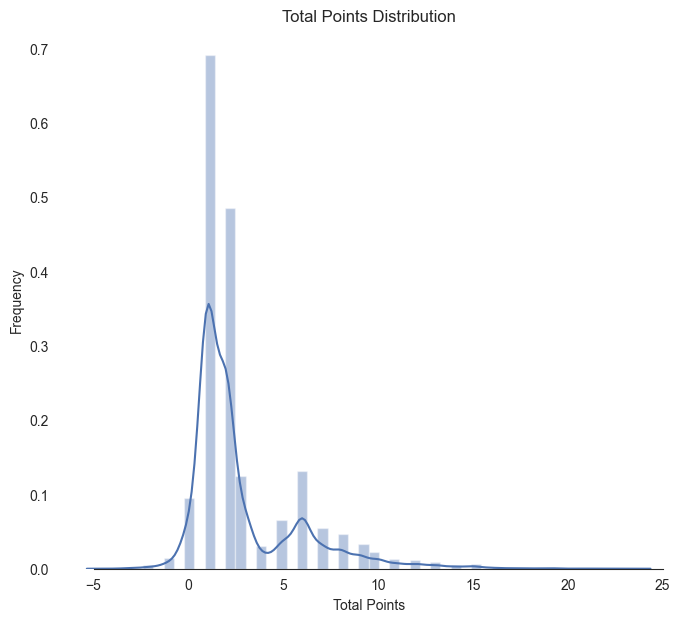

In [2616]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(y_train, color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Total Points")
ax.set(title="Total Points Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [2617]:
# skew and kurt
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

Skewness: 1.940315
Kurtosis: 4.371111


#### Problem #1: Total points is highly skewed to the right
This is a problem because most ML models don't do well with non-normally distributed data
#### Problem #2: Total points is also bimodal
This is even a bigger issue since normalization might not help
##### Solution: Try applying a log(x) tranform to fix the skew


In [2618]:
# shift total points to a minimum of 1 to avoid negatives before taking log transformation
atleastOneOffset = 1.000001-y_train.min()
y_train_transform = np.log(y_train+(atleastOneOffset))
print('Offset before taking the log :' + str(atleastOneOffset))

Offset before taking the log :5.000001


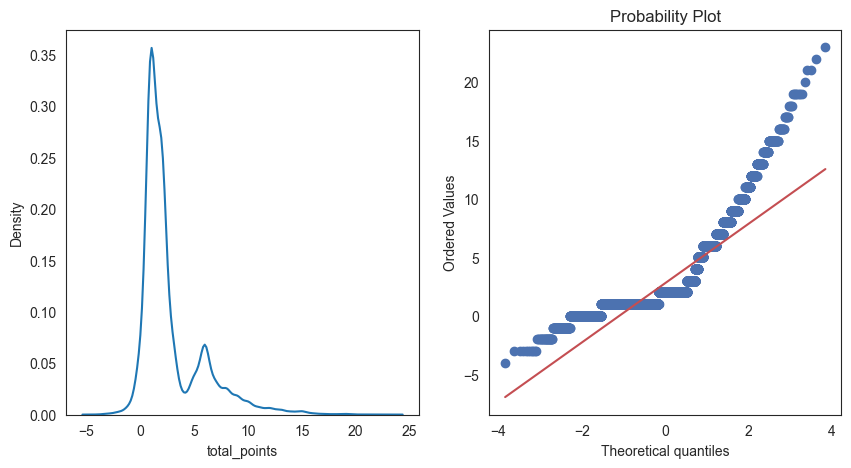

In [2619]:
#function to return plots and QoQ plot for the dataframe
def normality(df):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(df)
    plt.subplot(1,2,2)
    stats.probplot(df, plot=pylab)
    plt.show()

# plot dependent variable without transformation
normality(y_train)

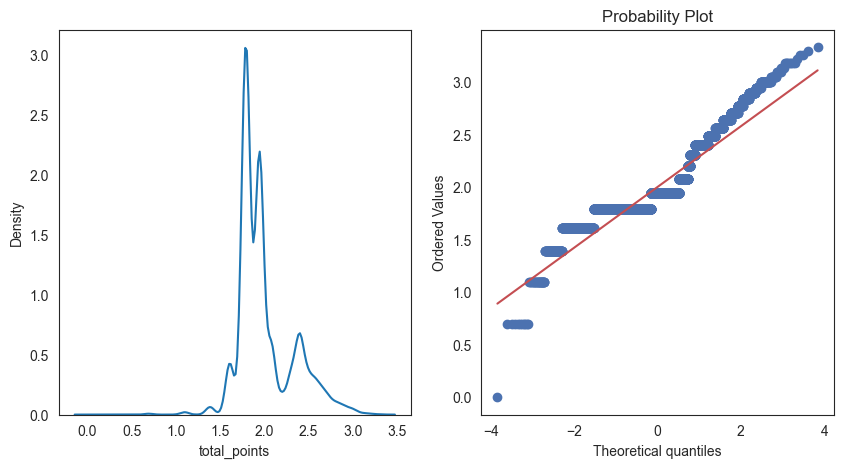

In [2620]:
# plot dependent variable with log transformation
normality(y_train_transform)

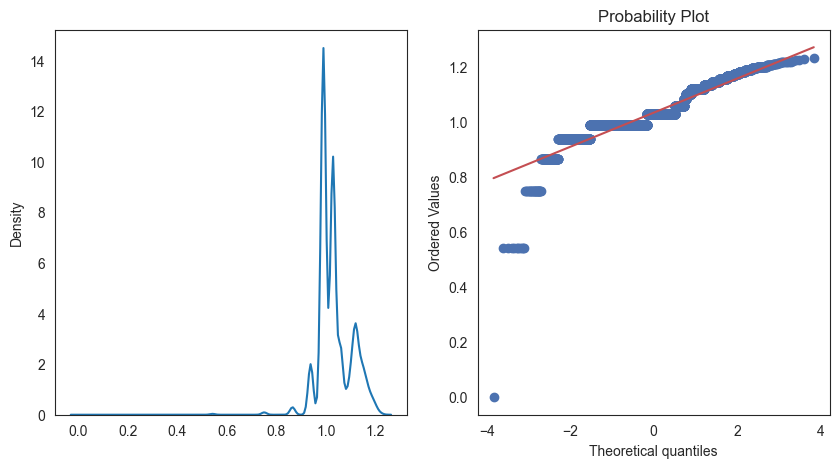

In [2621]:
# plot dependent variable with boxcox transformation
y_train_transform_cox, parameters = stats.boxcox(y_train+(1.000001-y_train.min()))
normality(y_train_transform_cox)

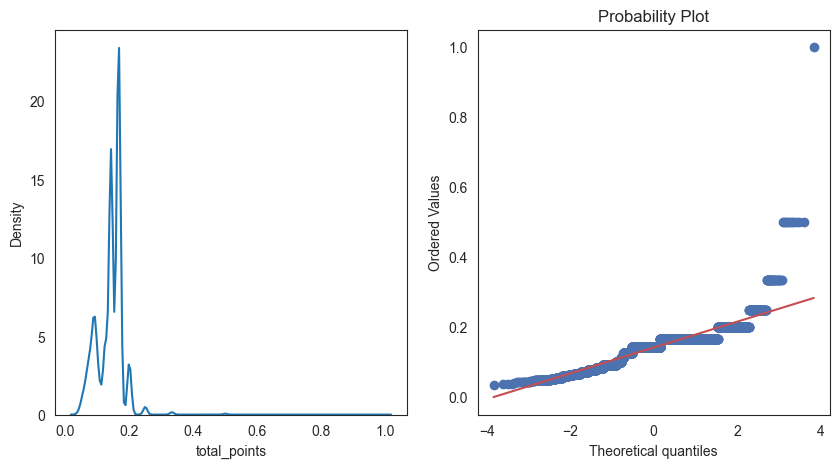

In [2622]:
y_train_transform_reciprocal = 1/(y_train+(1.000001-y_train.min()))
normality(y_train_transform_reciprocal)

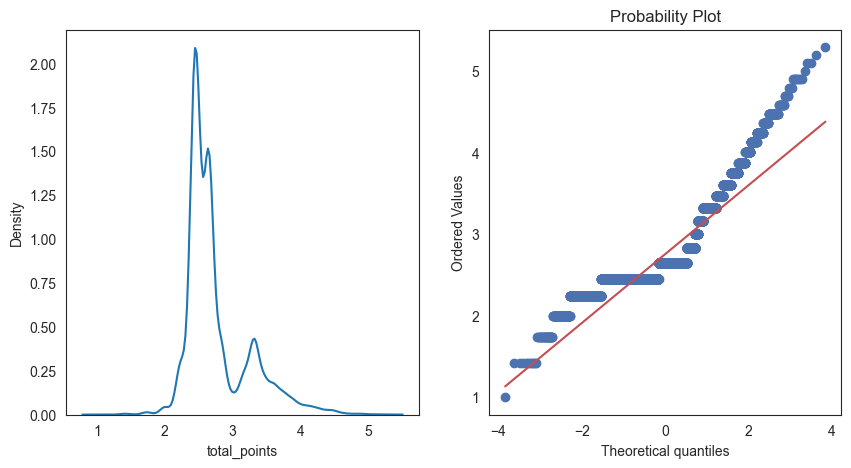

In [2623]:
y_train_transform_sqrt = np.sqrt(y_train+(1.000001-y_train.min()))
normality(y_train_transform_sqrt)

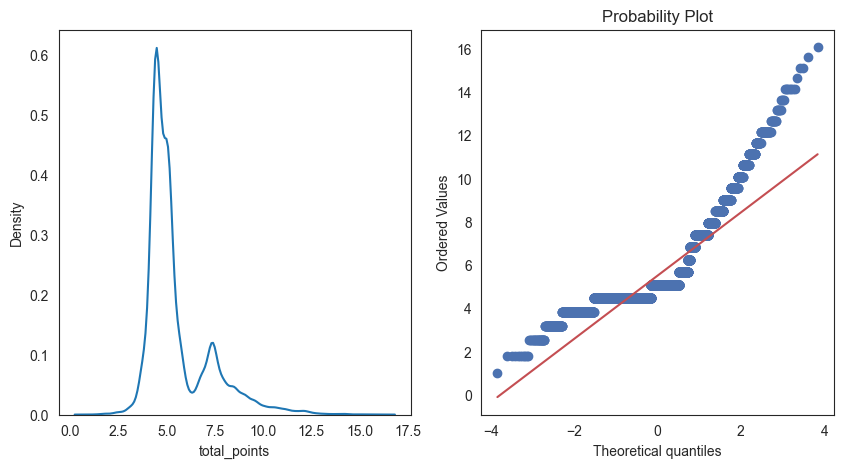

In [2624]:
# y_train_transform_exp = (y_train+(1.000001-y_train.min()))**(1/1.2)
y_train_transform_exp = (y_train+(1.000001-y_train.min()))**(1/1.2)
normality(y_train_transform_exp)


 mu = 2.00 and sigma = 0.31



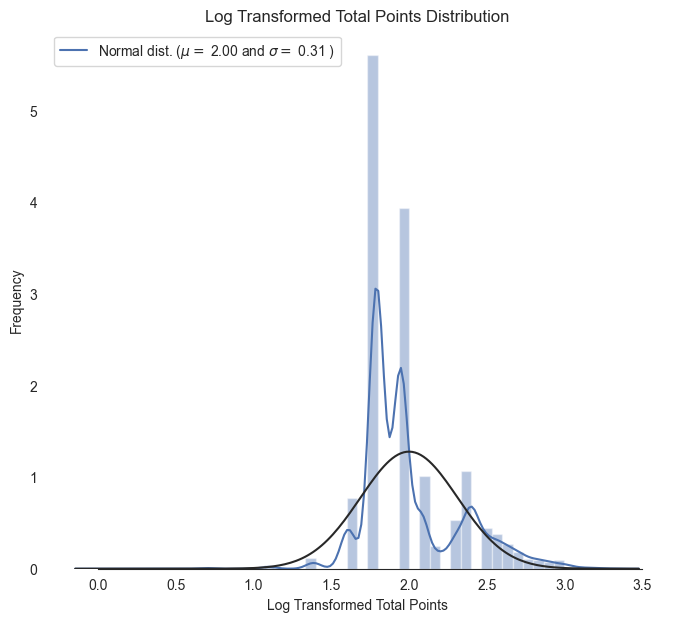

In [2625]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(y_train_transform , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train_transform)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Log Transformed Total Points")
ax.set(title="Log Transformed Total Points Distribution")
sns.despine(trim=True, left=True)

plt.show()

In [2626]:
print('skew before transformation: ' + str(y_train.skew()))
print('skew after transformation: ' + str(y_train_transform.skew()))
print('kurtosis before transformation: ' + str(y_train.kurt()))
print('kurtosis after transformation: ' + str(y_train_transform.kurt()))

skew before transformation: 1.9403154757501624
skew after transformation: 0.9918927952934994
kurtosis before transformation: 4.37111073822733
kurtosis after transformation: 1.2230376951987152


##### Based on charts log transformed depedent variable "Total Points" is closer to normal distribution but definitely not normal
##### Have to live with this as no other options

In [2627]:
# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([X_train, X_test]).reset_index(drop=True)
all_features.shape

(31385, 71)

In [2629]:
# fitting the PCA object onto our dataframe (excluding the model name column)
pca_columns = ['Corners', 'Crossing',
       'Dribbling', 'Finishing', 'First Touch', 'Free Kick Taking', 'Heading',
       'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking',
       'Tackling', 'Technique', 'Aggressiion', 'Anticipation', 'Bravery',
       'Composure', 'Concentration', 'Vision', 'Decision', 'Determination',
       'Flair', 'Leadership', 'Off The Ball', 'Position.1', 'Teamwork',
       'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach',
       'Natural Fitness', 'Pace', 'Stamina', 'Strength', 'Stability', 'Foul',
       'Contest performance', 'Injury', 'diversity', 'Aerial Reach',
       'Command Of Area', 'Communication', 'Eccentricity', 'Handling',
       'Kicking', 'One On Ones', 'Reflexes', 'Rushing Out', 'Punching',
       'Throwing']

df_pca = all_features[pca_columns]

# standardization
df_pca_scaled_data = StandardScaler().fit_transform(df_pca)
df_pca_scaled = pd.DataFrame(df_pca_scaled_data, columns=df_pca.columns)

In [2630]:
# fit scaled PCA dataframe
pca = PCA(n_components=10).fit(df_pca_scaled)

# transforming the dataframe
pca_features = pca.transform(df_pca_scaled)

print('Original dimensions:', df_pca.shape)
print('PCA dimensions:     ', pca_features.shape)

Original dimensions: (31385, 52)
PCA dimensions:      (31385, 10)


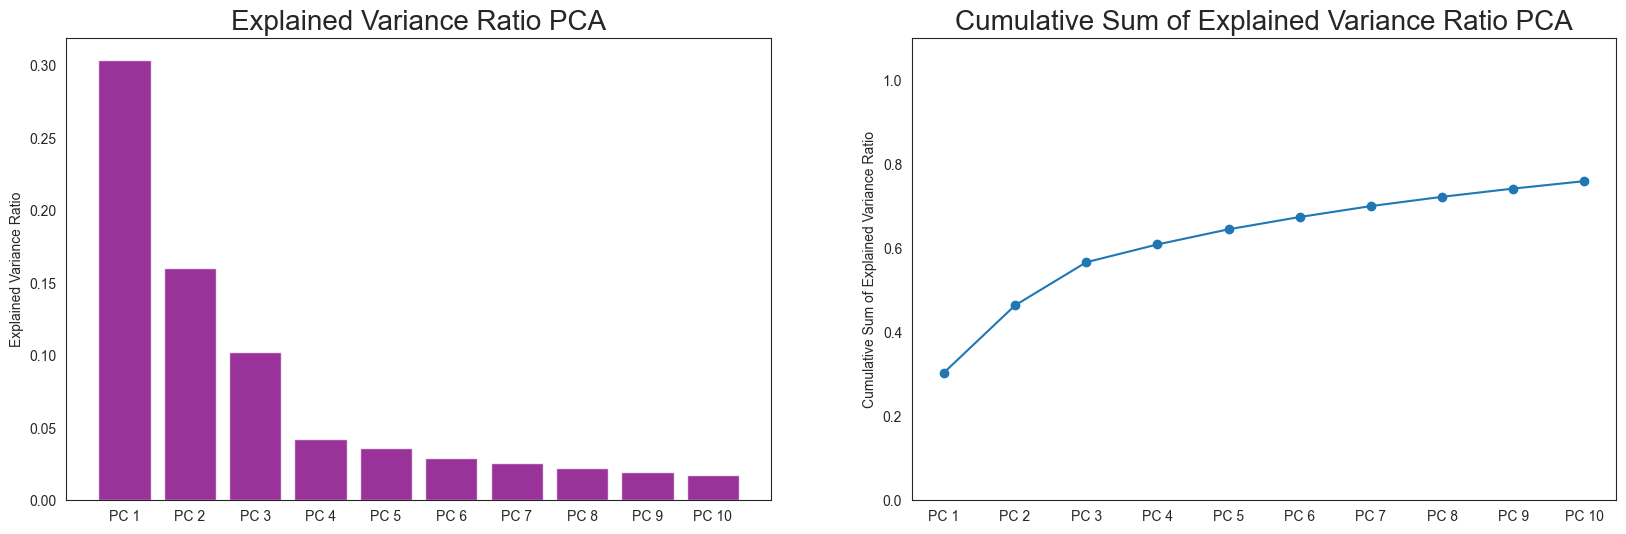

In [2631]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

80% of player generic attributes are still captured by the 10 CPA components while allowing dimensionality reduction, therefore, proceed with using the 10 PCA components

In [2699]:
print('PCA in expression:\n')
for i, comp in enumerate(pca.components_):
    expression = 'PCA_{} = '.format(i+1)
    for c, x in zip(comp, pca_columns):
        if c < 0:
            expression += str(np.round(c,2)) + '*' + x + ' '
        else:
            expression += '+' + str(np.round(c,2)) + '*' + x + ' '
    print(expression + '\n')

PCA in expression:

PCA_1 = -0.15*Corners -0.2*Crossing -0.22*Dribbling -0.18*Finishing -0.15*First Touch -0.13*Free Kick Taking -0.06*Heading -0.18*Long Shots -0.07*Long Throws -0.09*Marking -0.1*Passing -0.15*Penalty Taking -0.1*Tackling -0.16*Technique -0.05*Aggressiion -0.01*Anticipation +0.04*Bravery -0.04*Composure +0.03*Concentration -0.11*Vision -0.03*Decision -0.01*Determination -0.16*Flair +0.02*Leadership -0.18*Off The Ball +0.08*Position.1 -0.04*Teamwork -0.09*Work Rate -0.12*Acceleration -0.01*Agility -0.04*Balance +0.11*Jumping Reach -0.03*Natural Fitness -0.13*Pace -0.09*Stamina +0.04*Strength +0.02*Stability -0.04*Foul +0.0*Contest performance -0.02*Injury -0.1*diversity +0.23*Aerial Reach +0.22*Command Of Area +0.22*Communication +0.19*Eccentricity +0.23*Handling +0.22*Kicking +0.23*One On Ones +0.23*Reflexes +0.22*Rushing Out +0.21*Punching +0.22*Throwing 

PCA_2 = +0.11*Corners +0.05*Crossing +0.09*Dribbling +0.1*Finishing +0.04*First Touch +0.09*Free Kick Taking -0.

In [2633]:
df_pca_features = pd.DataFrame(pca_features, columns = ['PCA1','PCA2','PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10'])
df_pca_features.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,-1.128502,2.096941,0.149686,-0.968604,-0.836747,-0.179091,-1.049796,0.029803,-0.198740,1.750316
1,-1.436794,3.254619,0.160408,1.207609,-0.497221,0.927184,-1.401727,0.879278,0.845475,-1.915960
2,-0.769066,1.990874,-3.132554,-2.441068,2.182946,-0.569854,-0.529815,-0.306323,-0.348307,-1.167926
3,-0.428220,-3.042119,-0.906745,2.045257,2.583176,-1.106113,1.182098,0.178483,-0.135626,0.645088
4,1.649400,-5.370303,-1.327481,1.751393,1.574643,2.069863,-0.436654,1.053728,1.286915,0.850809


In [2634]:
all_features = pd.concat([all_features, df_pca_features], axis=1)
all_features = all_features[['weekday', 'minutes', 'was_home', 'Age', 'Left Foot', 'Right Foot',
       'vs_opp_ca', 'vs_opp_height', 'vs_opp_weight', 'team_defence_ca', 'team_attack_ca', 'opponent_left_foot',
       'opponent_right_foot', 'DEF', 'FWD', 'GK', 'MID', 'AM', 'PM', 'PCA1',
       'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
       'PCA10']]
all_features.head()

,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,DEF,FWD,GK,MID,AM,PM,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,5,1,0,28.0,8.0,20.0,0.875817,0.860697,0.757576,135.500000,135.111111,20.0,20.0,False,False,False,True,False,True,-1.128502,2.096941,0.149686,-0.968604,-0.836747,-0.179091,-1.049796,0.029803,-0.198740,1.750316
1,5,1,1,32.0,9.0,20.0,0.777070,0.924242,0.865169,127.176471,128.923077,20.0,20.0,False,False,False,True,False,True,-1.436794,3.254619,0.160408,1.207609,-0.497221,0.927184,-1.401727,0.879278,0.845475,-1.915960
2,5,15,0,20.0,10.0,20.0,0.924658,0.974490,0.903614,143.958333,144.392857,20.0,20.0,False,True,False,False,False,True,-0.769066,1.990874,-3.132554,-2.441068,2.182946,-0.569854,-0.529815,-0.306323,-0.348307,-1.167926
3,5,90,1,30.0,12.0,20.0,0.958333,0.979167,0.933333,134.761905,136.962963,20.0,20.0,True,False,False,False,False,True,-0.428220,-3.042119,-0.906745,2.045257,2.583176,-1.106113,1.182098,0.178483,-0.135626,0.645088
4,6,90,1,34.0,16.0,20.0,1.034965,1.005348,0.885057,142.333333,148.666667,20.0,20.0,True,False,False,False,False,True,1.649400,-5.370303,-1.327481,1.751393,1.574643,2.069863,-0.436654,1.053728,1.286915,0.850809


In [2635]:
# determine the threshold for missing values
def percentMissing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

# function to print missing data
def printMissing(all_features):
    missing = percentMissing(all_features)
    df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
    print('Percent of missing data')
    print(df_miss[0:10])
    return missing

missing = printMissing(all_features)

Percent of missing data
[('weekday', 0.0), ('minutes', 0.0), ('was_home', 0.0), ('Age', 0.0), ('Left Foot', 0.0), ('Right Foot', 0.0), ('vs_opp_ca', 0.0), ('vs_opp_height', 0.0), ('vs_opp_weight', 0.0), ('team_defence_ca', 0.0)]


In [2636]:
# fucntion to fill N/A for PCA fields
def fillNAforPCA(all_features, missing):
    for key, value in missing.items():
        if value > 0 and 'PCA' in key:
            all_features[key].fillna(0, inplace=True)
    return all_features

all_features = fillNAforPCA(all_features, missing)

In [2637]:
missing = printMissing(all_features)

Percent of missing data
[('weekday', 0.0), ('minutes', 0.0), ('was_home', 0.0), ('Age', 0.0), ('Left Foot', 0.0), ('Right Foot', 0.0), ('vs_opp_ca', 0.0), ('vs_opp_height', 0.0), ('vs_opp_weight', 0.0), ('team_defence_ca', 0.0)]


Proof for no missing data, continue

In [2638]:
# function to get all numeric features
def getNumericFeatures(features):
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    return numeric

numeric = getNumericFeatures(all_features)

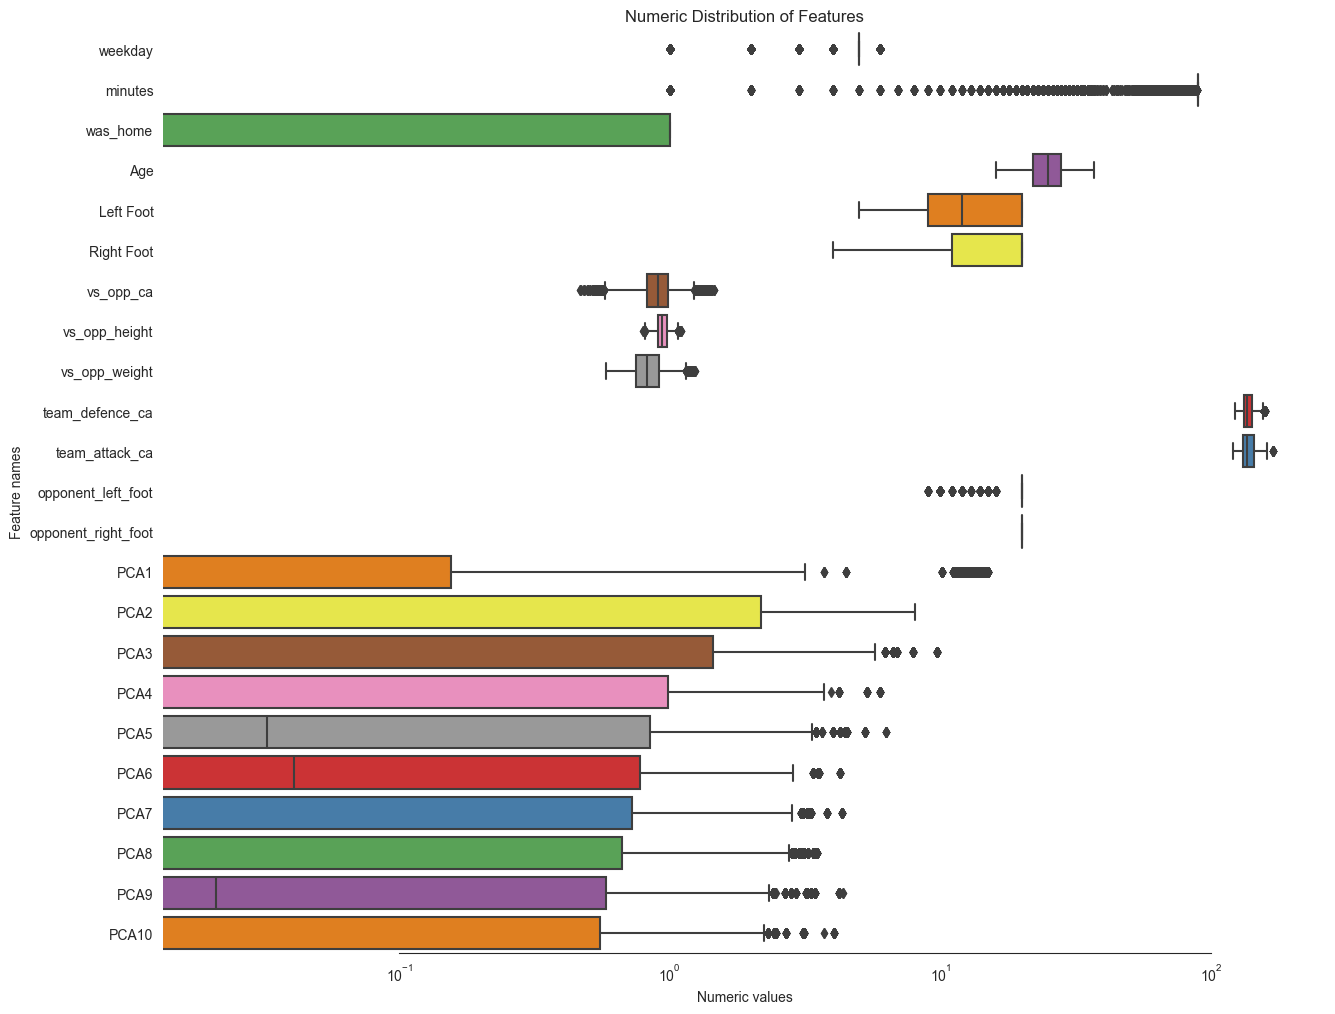

In [2639]:
# create box plots for all numeric features
def createBoxPlots(all_features, numeric):
    sns.set_style("white")
    f, ax = plt.subplots(figsize=(15,12))
    ax.set_xscale("log")
    ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
    ax.xaxis.grid(False)
    ax.set(ylabel="Feature names")
    ax.set(xlabel="Numeric values")
    ax.set(title="Numeric Distribution of Features")
    sns.despine(trim=True, left=True)

createBoxPlots(all_features, numeric)

In [2640]:
# Find skewed numerical features
def getSkewedNumericalFeatures(all_features, numeric):
    skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index

    print("There are {} numerical features out of {} features with Skew > 0.5 :".format(high_skew.shape[0], all_features.shape[1]))
    # skewness = pd.DataFrame({'Skew' :high_skew})
    # skew_features.head(10)

    return skew_index, skew_features

skew_index, skew_features = getSkewedNumericalFeatures(all_features, numeric)
skew_features.head(15)

There are 3 numerical features out of 29 features with Skew > 0.5 :


PCA1               2.616115
team_defence_ca    0.590363
PCA3               0.513002
Left Foot          0.453705
team_attack_ca     0.383858
Age                0.339797
PCA8               0.292503
vs_opp_ca          0.285769
PCA5               0.192570
vs_opp_height      0.182260
PCA7               0.156883
PCA9               0.103281
PCA2               0.078007
PCA10              0.075760
was_home           0.000956
dtype: float64

In [2641]:
skew_features

PCA1                   2.616115
team_defence_ca        0.590363
PCA3                   0.513002
Left Foot              0.453705
team_attack_ca         0.383858
Age                    0.339797
PCA8                   0.292503
vs_opp_ca              0.285769
PCA5                   0.192570
vs_opp_height          0.182260
PCA7                   0.156883
PCA9                   0.103281
PCA2                   0.078007
PCA10                  0.075760
was_home               0.000956
PCA4                  -0.083310
PCA6                  -0.149477
Right Foot            -1.106678
weekday               -1.808617
vs_opp_weight         -2.074978
minutes               -2.586210
opponent_left_foot    -3.997119
opponent_right_foot         NaN
dtype: float64

In [2642]:
# apply simple log transformation to normalize skewed features
for i in skew_index:
    all_features[i] = np.log10(all_features[i])

In [2643]:
skew_index, skew_features = getSkewedNumericalFeatures(all_features, numeric)
skew_features.head(15)

There are 0 numerical features out of 29 features with Skew > 0.5 :


Left Foot          0.453705
team_defence_ca    0.437263
team_attack_ca     0.383858
Age                0.339797
PCA8               0.292503
vs_opp_ca          0.285769
PCA5               0.192570
vs_opp_height      0.182260
PCA7               0.156883
PCA9               0.103281
PCA2               0.078007
PCA10              0.075760
was_home           0.000956
PCA4              -0.083310
PCA6              -0.149477
dtype: float64

In [2644]:
# check for features with N/A
missing = printMissing(all_features)

# fill N/A for PCA fields 
all_features = fillNAforPCA(all_features, missing)
# missing = percent_missing(all_features)
# for key, value in missing.items():
#     if value > 0 and 'PCA' in key:
#         all_features[key].fillna(0, inplace=True)

Percent of missing data
[('PCA1', 72.89), ('PCA3', 53.21), ('weekday', 0.0), ('minutes', 0.0), ('was_home', 0.0), ('Age', 0.0), ('Left Foot', 0.0), ('Right Foot', 0.0), ('vs_opp_ca', 0.0), ('vs_opp_height', 0.0)]


In [2645]:
# check for features with N/A
missing = printMissing(all_features)

Percent of missing data
[('weekday', 0.0), ('minutes', 0.0), ('was_home', 0.0), ('Age', 0.0), ('Left Foot', 0.0), ('Right Foot', 0.0), ('vs_opp_ca', 0.0), ('vs_opp_height', 0.0), ('vs_opp_weight', 0.0), ('team_defence_ca', 0.0)]


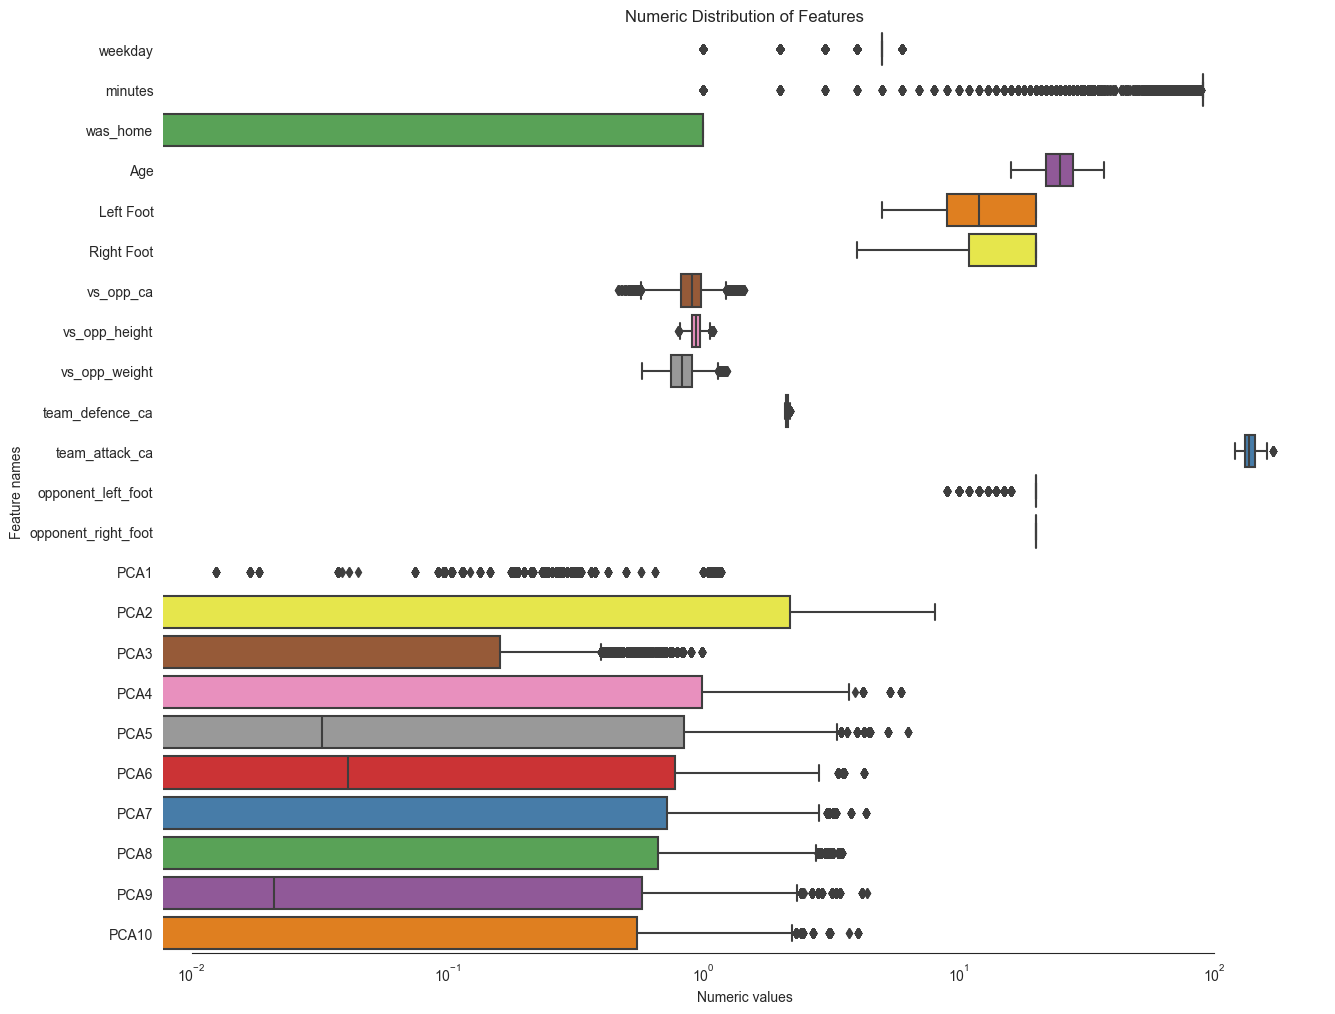

In [2646]:
createBoxPlots(all_features, numeric)

skews for features look much closer to normal after log transformation

In [2647]:
# update boolean columns to integer so that machine learning models can understand
boolean_dtypes = ['bool']
for i in all_features.columns:
        if all_features[i].dtype in boolean_dtypes:
            all_features[i] = all_features[i].astype(int)

In [2648]:
all_features.head()

,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,DEF,FWD,GK,MID,AM,PM,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,5,1,0,28.0,8.0,20.0,0.875817,0.860697,0.757576,2.131939,135.111111,20.0,20.0,0,0,0,1,0,1,0.000000,2.096941,-0.824818,-0.968604,-0.836747,-0.179091,-1.049796,0.029803,-0.198740,1.750316
1,5,1,1,32.0,9.0,20.0,0.777070,0.924242,0.865169,2.104407,128.923077,20.0,20.0,0,0,0,1,0,1,0.000000,3.254619,-0.794775,1.207609,-0.497221,0.927184,-1.401727,0.879278,0.845475,-1.915960
2,5,15,0,20.0,10.0,20.0,0.924658,0.974490,0.903614,2.158237,144.392857,20.0,20.0,0,1,0,0,0,1,0.000000,1.990874,0.000000,-2.441068,2.182946,-0.569854,-0.529815,-0.306323,-0.348307,-1.167926
3,5,90,1,30.0,12.0,20.0,0.958333,0.979167,0.933333,2.129567,136.962963,20.0,20.0,1,0,0,0,0,1,0.000000,-3.042119,0.000000,2.045257,2.583176,-1.106113,1.182098,0.178483,-0.135626,0.645088
4,6,90,1,34.0,16.0,20.0,1.034965,1.005348,0.885057,2.153307,148.666667,20.0,20.0,1,0,0,0,0,1,0.217326,-5.370303,0.000000,1.751393,1.574643,2.069863,-0.436654,1.053728,1.286915,0.850809


## Recreate training and test sets

In [2649]:
X_train = all_features.iloc[:len(y_train), :]
X_test = all_features.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape

((11293, 29), (11293,), (20092, 29))

## Find the optimal parameters for each model and evaluate performance <a class="anchor" id="eighth-bullet"></a>

## Key features of the model training process:
- **Cross Validation:** Using 12-fold cross-validation
- **Models:** On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** In addition, I trained a meta StackingCVRegressor optimized using xgboost
- **Blending:** All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

## Setup cross validation and define error metrics

In [2650]:
# setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [2651]:
# define error metrics
# function to calculate root mean squared logarithmic error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# function to calculate root mean squared error
def cv_rmse(model, X_train=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train_transform, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# function to calculate r square
def cv_r2(model, X_train=X_train):
    r2 = cross_val_score(model, X_train, y_train_transform, scoring="r2", cv=kf)
    return (r2)

In [2652]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Train models

In [2673]:
scores = {}

score = cv_rmse(lightgbm)
print("RMSE for lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

RMSE for lightgbm: 0.2696 (0.0068)


In [2674]:
scores = {}

score = cv_r2(lightgbm)
print("R-Square for lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

R-Square for lightgbm: 0.2539 (0.0192)


In [2675]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[13:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

In [2676]:
score = cv_r2(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[13:15:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

In [2677]:
score = cv_r2(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.0788 (0.0151)


In [2678]:
score = cv_r2(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.2006 (0.0168)


In [2659]:
score = cv_r2(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.2372 (0.0236)


In [2679]:
score = cv_r2(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.2600 (0.0169)


## Fit the models for prediction <a class="anchor" id="nineth-bullet"></a>

In [2661]:
rf_model_full_data = rf.fit(X_train, y_train_transform)

<BarContainer object of 29 artists>

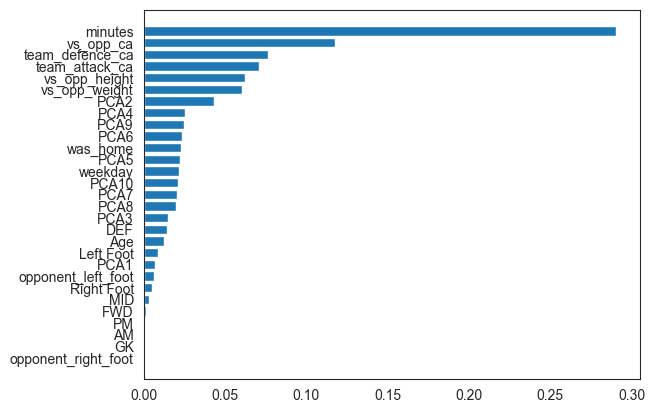

In [2662]:
# show important independent variables/predictors
importance_indx = rf.feature_importances_.argsort()
plt.barh(all_features.columns[importance_indx], rf.feature_importances_[importance_indx])

## Make predictions <a class="anchor" id="tenth-bullet"></a>

In [2663]:
# get prediction while descale
predictions = np.exp(rf_model_full_data.predict(X_test)) - atleastOneOffset
df_pred = df_model[df_model['season'] == '2023-24']
df_pred['predicted_points'] = predictions

In [2664]:
df_pred = df_pred.sort_values('predicted_points', ascending=False)
df_pred.head()

,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,total_points,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,season,name,GW,team,opponent_team_name,DEF,FWD,GK,MID,AM,PM,predicted_points
19494,2,90,1,22.0,20.0,11.0,1.178344,0.984848,0.988764,7.0,10.0,14.0,18.0,16.0,13.0,15.0,13.0,5.0,6.0,13.0,17.0,7.0,15.0,13.0,18.0,15.0,18.0,15.0,14.0,13.0,20.0,16.0,13.0,18.0,7.0,13.0,13.0,17.0,16.0,17.0,18.0,19.0,19.0,14.0,17.0,17.0,9.0,17.0,12.0,10.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,0,155.842105,155.826087,20.0,20.0,2023-24,Erling Haaland,31,Man City,Aston Villa,False,True,False,False,False,True,8.162001
20782,5,90,1,22.0,20.0,11.0,1.312057,1.005155,0.988764,7.0,10.0,14.0,18.0,16.0,13.0,15.0,13.0,5.0,6.0,13.0,17.0,7.0,15.0,13.0,18.0,15.0,18.0,15.0,14.0,13.0,20.0,16.0,13.0,18.0,7.0,13.0,13.0,17.0,16.0,17.0,18.0,19.0,19.0,14.0,17.0,17.0,9.0,17.0,12.0,10.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,0,155.555556,156.000000,20.0,20.0,2023-24,Erling Haaland,36,Man City,Wolves,False,True,False,False,False,True,8.005139
15717,5,90,1,22.0,20.0,11.0,1.293706,1.010363,1.035294,7.0,10.0,14.0,18.0,16.0,13.0,15.0,13.0,5.0,6.0,13.0,17.0,7.0,15.0,13.0,18.0,15.0,18.0,15.0,14.0,13.0,20.0,16.0,13.0,18.0,7.0,13.0,13.0,17.0,16.0,17.0,18.0,19.0,19.0,14.0,17.0,17.0,9.0,17.0,12.0,10.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,0,152.888889,156.272727,20.0,20.0,2023-24,Erling Haaland,17,Man City,Crystal Palace,False,True,False,False,False,True,7.940958
18386,5,90,1,28.0,19.0,20.0,1.279720,0.974093,1.011765,9.0,15.0,14.0,19.0,15.0,10.0,15.0,15.0,6.0,10.0,18.0,20.0,11.0,16.0,11.0,15.0,14.0,18.0,15.0,18.0,18.0,19.0,12.0,15.0,16.0,12.0,18.0,16.0,12.0,12.0,14.0,13.0,16.0,14.0,16.0,15.0,17.0,8.0,14.0,12.0,9.0,1.0,1.0,3.0,1.0,3.0,2.0,1.0,2.0,2.0,3.0,1.0,0,143.681818,149.523810,20.0,20.0,2023-24,Harry Kane,27,Spurs,Crystal Palace,False,True,False,False,False,True,7.928146
15699,5,90,1,30.0,20.0,8.0,1.156250,0.902062,0.720000,12.0,14.0,17.0,17.0,17.0,12.0,10.0,13.0,6.0,7.0,15.0,17.0,7.0,17.0,11.0,16.0,11.0,15.0,15.0,17.0,15.0,18.0,15.0,11.0,18.0,9.0,15.0,16.0,18.0,16.0,18.0,8.0,17.0,18.0,15.0,15.0,15.0,6.0,16.0,4.0,7.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,0,155.111111,147.608696,20.0,20.0,2023-24,Mohamed Salah,17,Liverpool,Man Utd,False,False,False,True,False,True,7.542421


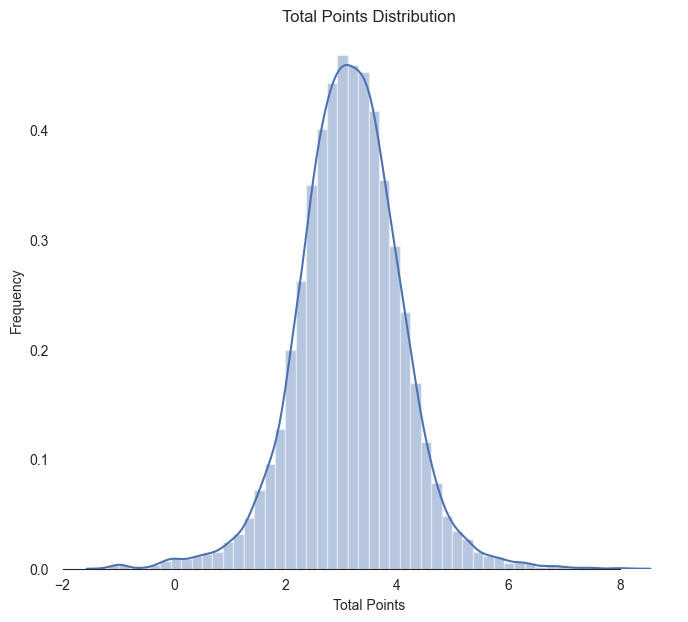

In [2665]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_pred['predicted_points'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Total Points")
ax.set(title="Total Points Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [2667]:
df_pred.to_csv('Output/predictions_all_fixtures.csv', index=False)

In [2668]:
# next 5 game week player ranking
df_pred_next_5_gw = df_pred[df_pred['GW'] <= 5]
df_pred_next_5_gw_ranking = pd.pivot_table(df_pred_next_5_gw, values = 'predicted_points', index=['name'], columns = 'GW', aggfunc=sum, margins=True).reset_index().sort_values(by='All', ascending=False).iloc[1:,:]

In [2669]:
print('Predicted player ranking for next 5 games:')
df_pred_next_5_gw_ranking.head(30)

Predicted player ranking for next 5 games:


GW,name,1,2,3,4,5,All
156,Erling Haaland,7.437878,5.983889,6.774478,6.628426,6.176007,33.000677
192,Harry Kane,6.377818,6.243075,4.315622,6.679123,5.697285,29.312924
354,Martin Ødegaard,5.582193,4.149778,5.399286,5.669188,6.084027,26.884472
346,Marcus Rashford,6.442344,4.088179,6.570764,4.416764,5.001076,26.519127
174,Gabriel Martinelli Silva,5.449289,6.204710,4.450221,4.766389,5.107501,25.978109
425,Phil Foden,5.288521,5.041987,5.073305,5.987843,4.256795,25.648450
297,Kevin De Bruyne,4.977283,4.950893,5.676588,4.820708,5.146877,25.572349
380,Mohamed Salah,4.875774,3.446790,5.662350,6.262378,4.898850,25.146141
77,Callum Wilson,6.285698,3.958468,4.870988,4.625733,5.339438,25.080324
74,Bukayo Saka,5.101535,4.484727,5.156804,6.014543,4.138718,24.896326


In [2689]:
def getPredictedRankingDFByPosition(df_pred, position, num_gws=5):
    df_pred_position = df_pred[(df_pred[position] == True) & (df_pred['GW'] <= num_gws)]
    df_pred_ranking = pd.pivot_table(df_pred_position, values = 'predicted_points', index=['name'], columns = 'GW', aggfunc=sum, margins=True).reset_index().sort_values(by='All', ascending=False).iloc[1:,:]
    # print('Predicted ' + position + ' ranking for next 5 games:')
    return df_pred_ranking

In [2697]:
positions = ['GK', 'DEF', 'MID', 'FWD']

for position in positions:
    print('Predicted ' + position + ' ranking for next 5 games:')
    df_pred_ranking = getPredictedRankingDFByPosition(df_pred, position, 5)
    display(df_pred_ranking.head(15))

# df_pred_ranking.head(10)

Predicted GK ranking for next 5 games:


GW,name,1,2,3,4,5,All
39,Stefan Ortega Moreno,4.048057,5.578124,3.752013,5.746146,4.523092,23.647432
45,Zack Steffen,4.268073,3.691892,3.922684,4.253058,3.832157,19.967864
24,Kepa Arrizabalaga,3.613077,3.470420,4.340777,4.256415,3.692556,19.373245
2,Alisson Ramses Becker,3.610944,4.095685,3.523385,4.723499,3.340362,19.293873
11,Ederson Santana de Moraes,3.918577,3.713505,3.734660,3.582120,3.997551,18.946413
33,Matt Turner,4.349669,3.822710,3.758243,3.387600,3.522999,18.841221
13,Emiliano Martínez Romero,3.575347,4.015736,4.051184,2.692350,4.491451,18.826068
7,Caoimhin Kelleher,3.352022,4.202871,3.368453,4.417620,3.379508,18.720473
21,José Malheiro de Sá,2.464283,4.424092,3.292192,3.697037,4.447985,18.325588
0,Aaron Ramsdale,3.840181,4.290262,3.676750,2.641701,3.784359,18.233253


Predicted DEF ranking for next 5 games:


GW,name,1,2,3,4,5,All
131,Nathan Aké,4.317222,3.787813,4.149437,4.411791,4.635040,21.301302
145,Pedro Porro,3.699501,4.948398,3.925380,3.914385,4.367103,20.854766
96,Kieran Trippier,6.112412,2.363385,2.406013,4.725804,4.895022,20.502636
89,João Cancelo,4.389365,3.888710,3.949124,3.599685,4.587915,20.414800
17,Ben Davies,3.943270,3.682063,4.233917,4.048964,4.174048,20.082262
163,Sergio Gómez,3.699233,4.461428,3.960804,4.588369,3.075576,19.785411
157,Ryan Sessegnon,3.635749,3.242547,4.338632,4.135776,4.402634,19.755337
140,Oleksandr Zinchenko,3.776851,5.134833,3.916053,2.613789,4.116311,19.557836
22,Benjamin White,4.270698,4.162969,3.920266,2.926796,4.106352,19.387081
53,Gabriel dos Santos Magalhães,3.985154,4.498738,4.480039,2.252153,3.785934,19.002017


Predicted MID ranking for next 5 games:


GW,name,1,2,3,4,5,All
158,Martin Ødegaard,5.582193,4.149778,5.399286,5.669188,6.084027,26.884472
155,Marcus Rashford,6.442344,4.088179,6.570764,4.416764,5.001076,26.519127
75,Gabriel Martinelli Silva,5.449289,6.204710,4.450221,4.766389,5.107501,25.978109
191,Phil Foden,5.288521,5.041987,5.073305,5.987843,4.256795,25.648450
136,Kevin De Bruyne,4.977283,4.950893,5.676588,4.820708,5.146877,25.572349
169,Mohamed Salah,4.875774,3.446790,5.662350,6.262378,4.898850,25.146141
35,Bukayo Saka,5.101535,4.484727,5.156804,6.014543,4.138718,24.896326
140,Leandro Trossard,5.197965,5.311303,5.092550,4.574683,4.395068,24.571568
199,Riyad Mahrez,4.653750,5.294577,4.336451,5.061888,4.553669,23.900334
196,Reiss Nelson,5.663453,4.092643,4.669899,4.685163,3.894451,23.005609


Predicted FWD ranking for next 5 games:


GW,name,1,2,3,4,5,All
26,Erling Haaland,7.437878,5.983889,6.774478,6.628426,6.176007,33.000677
33,Harry Kane,6.377818,6.243075,4.315622,6.679123,5.697285,29.312924
8,Callum Wilson,6.285698,3.958468,4.870988,4.625733,5.339438,25.080324
59,Taiwo Awoniyi,4.397561,5.861690,3.919092,3.679234,4.898488,22.756065
41,Julián Álvarez,4.393582,4.552692,4.391984,5.233485,3.958682,22.530425
23,Eddie Nketiah,4.282504,3.949556,4.032239,6.137786,3.695926,22.098010
36,Ivan Toney,4.959370,4.077247,3.349925,4.738970,4.272701,21.398214
28,Folarin Balogun,4.636506,3.764407,4.767047,4.425930,3.759027,21.352918
50,Ollie Watkins,3.845110,5.770393,3.765589,3.148789,4.530296,21.060177
30,Gabriel Fernando de Jesus,4.848332,3.776274,4.223029,4.653185,3.169722,20.670542


In [2670]:
df_pred_next_5_gw_ranking.to_csv('Output/predictions_next_5_gameweeks.csv', index=False)

In [2671]:
df_pred_ranking = pd.pivot_table(df_pred, values = 'predicted_points', index=['name'], columns = 'GW', aggfunc=sum, margins=True).reset_index().sort_values(by='All', ascending=False).iloc[1:,:]

In [2684]:
print('Predicted player ranking for remaining fixtures:')
df_pred_ranking.head()

Predicted player ranking for remaining fixtures:


GW,name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,All
192,Harry Kane,6.377818,6.243075,4.315622,6.679123,5.697285,5.301429,6.398867,6.144484,6.836081,6.922989,6.444883,5.773597,5.851835,5.136243,6.937377,6.327006,6.885254,7.469627,6.927210,4.146863,5.344090,6.881999,6.790606,7.264944,6.314512,5.828396,7.928146,5.727989,5.976112,6.716827,6.107967,7.452585,5.901900,5.698216,5.403286,6.213107,6.961303,6.307225,237.635879
156,Erling Haaland,7.437878,5.983889,6.774478,6.628426,6.176007,5.574648,7.104238,6.563903,7.438484,5.523510,4.840116,4.710089,5.747609,7.219674,6.339393,6.294834,7.940958,NaN,6.340042,6.164994,6.867767,6.140692,5.320899,6.328991,5.694825,4.859535,5.300227,4.824291,6.724606,6.373431,8.162001,7.203290,6.652005,4.719964,3.963131,8.005139,4.815206,6.690766,229.449937
380,Mohamed Salah,4.875774,3.446790,5.662350,6.262378,4.898850,5.225024,4.983644,3.813480,5.997408,5.171695,4.518008,5.549848,3.866304,6.380376,4.482300,3.199686,7.542421,3.982626,6.109677,4.827643,2.980639,4.585369,3.434150,5.490453,5.511472,4.649621,4.686490,4.477613,5.809597,6.281561,5.013234,6.760084,4.714330,6.679279,4.614015,6.886564,5.451518,5.397752,194.220020
354,Martin Ødegaard,5.582193,4.149778,5.399286,5.669188,6.084027,5.284483,4.751429,4.380460,4.394175,4.250019,5.984377,4.429758,5.802698,5.767850,4.639959,6.455928,5.152670,3.577620,5.767409,6.168862,4.267415,4.681906,4.326072,5.409974,4.546357,4.754615,4.377242,5.053735,5.308716,3.875132,4.797080,6.024377,4.994837,5.183015,5.656761,4.672458,3.874659,4.992416,190.488933
174,Gabriel Martinelli Silva,5.449289,6.204710,4.450221,4.766389,5.107501,4.600557,3.767935,4.514695,3.779545,4.490578,4.940910,5.301275,4.237942,5.648632,5.698784,4.636417,5.927173,6.310110,5.517426,4.791726,5.877383,4.130077,7.070887,4.205522,6.060423,4.969330,4.745773,4.697902,4.611885,3.874832,5.915501,5.685206,5.786074,4.884739,4.288856,4.332636,3.616117,5.591692,190.486647


In [2710]:
df_pred_cost = df_pred.merge(df_elements_short, how='left', on='name')
df_pred_cost.head()

,weekday,minutes_x,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,total_points,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,season,name,GW,team_x,opponent_team_name,DEF,FWD,GK,MID,AM,PM,predicted_points,id,team_y,position,selected_by_percent,minutes_y,now_cost,points_per_minute,ppm_over_cost
0,2,90,1,22.0,20.0,11.0,1.178344,0.984848,0.988764,7.0,10.0,14.0,18.0,16.0,13.0,15.0,13.0,5.0,6.0,13.0,17.0,7.0,15.0,13.0,18.0,15.0,18.0,15.0,14.0,13.0,20.0,16.0,13.0,18.0,7.0,13.0,13.0,17.0,16.0,17.0,18.0,19.0,19.0,14.0,17.0,17.0,9.0,17.0,12.0,10.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,0,155.842105,155.826087,20.0,20.0,2023-24,Erling Haaland,31,Man City,Aston Villa,False,True,False,False,False,True,8.162001,355.0,Man City,Forward,87.2,2767.0,14.0,0.098301,0.007022
1,5,90,1,22.0,20.0,11.0,1.312057,1.005155,0.988764,7.0,10.0,14.0,18.0,16.0,13.0,15.0,13.0,5.0,6.0,13.0,17.0,7.0,15.0,13.0,18.0,15.0,18.0,15.0,14.0,13.0,20.0,16.0,13.0,18.0,7.0,13.0,13.0,17.0,16.0,17.0,18.0,19.0,19.0,14.0,17.0,17.0,9.0,17.0,12.0,10.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,0,155.555556,156.000000,20.0,20.0,2023-24,Erling Haaland,36,Man City,Wolves,False,True,False,False,False,True,8.005139,355.0,Man City,Forward,87.2,2767.0,14.0,0.098301,0.007022
2,5,90,1,22.0,20.0,11.0,1.293706,1.010363,1.035294,7.0,10.0,14.0,18.0,16.0,13.0,15.0,13.0,5.0,6.0,13.0,17.0,7.0,15.0,13.0,18.0,15.0,18.0,15.0,14.0,13.0,20.0,16.0,13.0,18.0,7.0,13.0,13.0,17.0,16.0,17.0,18.0,19.0,19.0,14.0,17.0,17.0,9.0,17.0,12.0,10.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,0,152.888889,156.272727,20.0,20.0,2023-24,Erling Haaland,17,Man City,Crystal Palace,False,True,False,False,False,True,7.940958,355.0,Man City,Forward,87.2,2767.0,14.0,0.098301,0.007022
3,5,90,1,28.0,19.0,20.0,1.279720,0.974093,1.011765,9.0,15.0,14.0,19.0,15.0,10.0,15.0,15.0,6.0,10.0,18.0,20.0,11.0,16.0,11.0,15.0,14.0,18.0,15.0,18.0,18.0,19.0,12.0,15.0,16.0,12.0,18.0,16.0,12.0,12.0,14.0,13.0,16.0,14.0,16.0,15.0,17.0,8.0,14.0,12.0,9.0,1.0,1.0,3.0,1.0,3.0,2.0,1.0,2.0,2.0,3.0,1.0,0,143.681818,149.523810,20.0,20.0,2023-24,Harry Kane,27,Spurs,Crystal Palace,False,True,False,False,False,True,7.928146,500.0,Spurs,Forward,11.3,3406.0,12.5,0.077217,0.006177
4,5,90,1,30.0,20.0,8.0,1.156250,0.902062,0.720000,12.0,14.0,17.0,17.0,17.0,12.0,10.0,13.0,6.0,7.0,15.0,17.0,7.0,17.0,11.0,16.0,11.0,15.0,15.0,17.0,15.0,18.0,15.0,11.0,18.0,9.0,15.0,16.0,18.0,16.0,18.0,8.0,17.0,18.0,15.0,15.0,15.0,6.0,16.0,4.0,7.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,0,155.111111,147.608696,20.0,20.0,2023-24,Mohamed Salah,17,Liverpool,Man Utd,False,False,False,True,False,True,7.542421,308.0,Liverpool,Midfielder,23.6,3290.0,12.5,0.072644,0.005812


In [2711]:
df_pred_cost.to_csv('Output/predictions_all_fixture_with_cost.csv', index=False)

In [2727]:
team_url = ws.getTeamPlayerInfo()
team_url

TypeError: __init__() got an unexpected keyword argument 'executable_path'